In [248]:
#libraries
import pandas as pd
import datetime
from datetime import datetime
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Markdown as md
sns.set()

In [249]:
#styles for graphs
def styles():
    sns.set();
    sns.set(font_scale=1.5);
    #plot size
    plt.figure(figsize=(16, 5)); 


In [250]:
#%pip install --upgrade pip

In [251]:
#ignore warnings
import warnings
warnings.filterwarnings('ignore') # We can suppress the warnings

In [252]:
# stop fuzzy charts
%config InlineBackend.figure_format = "retina"

In [253]:
#pip install pandas==1.5.0

In [254]:
#import pickle file
filename ='../data/data.pkl'
infile = open(filename,'rb')
df = pickle.load(infile)

In [255]:
#view head
df.head(1)

Datetime             Tweet ID  \
0  2021-10-22 10:08:21+00:00  1451490603766886402   

                                                Text   Username  retweetCount  \
0  Missed our recent webinar with partners Social...  AdviceGov             0   

   likeCount                                           hashtags  
0          0  ['SocialValue', 'Gov', 'Procurement', 'PublicS...

## Feature enginnering 

In [256]:
#feature engineering date, month, year, week, day of year, day of week, 
df['Datetime'] = pd.to_datetime(df['Datetime'])
df['Date'] = pd.to_datetime(df['Datetime']).dt.date
df['Month'] = pd.to_datetime(df['Date']).dt.month
df['Year'] = pd.to_datetime(df['Date']).dt.year
df['Week'] = pd.to_datetime(df['Date']).dt.week
df['day_of_year'] = pd.to_datetime(df['Date']).dt.dayofyear
df['day_of_week'] = pd.to_datetime(df['Date']).dt.dayofweek
df['quarter'] = pd.to_datetime(df['Date']).dt.quarter
df['season'] = df['Month']%12 // 3 + 1

In [257]:
df.dtypes

Datetime        datetime64[ns, UTC]
Tweet ID                     object
Text                         object
Username                     object
retweetCount                  int64
likeCount                     int64
hashtags                     object
Date                         object
Month                         int64
Year                          int64
Week                          int64
day_of_year                   int64
day_of_week                   int64
quarter                       int64
season                        int64
dtype: object

In [258]:
df[['Date', 'Month','day_of_year', 'quarter','season']].head(2)

Date  Month  day_of_year  quarter  season
0  2021-10-22     10          295        4       4
1  2021-10-26     10          299        4       4

In [259]:
#get the word count of the tweet
df["word_count"] = df["Text"].apply(lambda x: len(str(x).split()))

In [260]:
#get the word count of the tweet
df["char_count"] = df["Text"].str.len()

In [261]:
#https://www.nltk.org/
import nltk #natural langugage toolkit

In [262]:
#download stopwords
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ritaraher/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [263]:
from nltk.corpus import stopwords
#remove stopwords
stop = stopwords.words("english")

In [264]:
# counting stop words
#stop words
df["stopwords"]= df["Text"].apply(lambda x: len([x for x in x.split() if x in stop]))

In [265]:
#count hashtags
df["hashtag_count"]= df["Text"].apply(lambda x: len([x for x in x.split() if x.startswith('#')]))

In [266]:
# Apply text cleaning techniques
import re
import string

def clean_text_round1(text):
    text = text.lower()                                              #lowercase
    text = re.sub('\[.*?\]', '', text)                               #remove the twitter handle
    text = re.sub('@[^\s]+', '', text)                               # remove text in square brackets
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)  # remove punctuation
    text = re.sub('\w*\d\w*', '', text)                              #remove words containing numbers
    text = re.sub('\n', '', text)                                    # remove \n
    return text

round1 = lambda x: clean_text_round1(x)

In [267]:
# Let's take a look at the updated text
df['tweet_clean'] = df.Text.apply(round1)

In [268]:
#removing stop words from tweet clean
df["tweet_clean"]= df["tweet_clean"].apply(lambda x : " ".join(x for x in x.split() if x not in stop))

### Sentiment feature engineering 

In [269]:
#pip install TextBlob

In [270]:
#pip install vaderSentiment

In [271]:
##semantic analysis
from textblob import TextBlob
df["tweet_clean"][:5].apply(lambda x : TextBlob(x).sentiment)

#   (-0.5, 1.0)
# break into polarity
df["polarity"]= df["tweet_clean"].apply(lambda x : TextBlob(x).sentiment[0])

df["subjectivity"]= df["tweet_clean"].apply(lambda x : TextBlob(x).sentiment[1])

In [272]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

In [273]:
df['sentiments_new'] = df['tweet_clean'].apply(lambda x: analyzer.polarity_scores(' '.join(re.findall(r'\w+',x.lower()))))

df['Positive Sentiment']   = df['sentiments_new'].apply(lambda x: x['pos']+1*(10**-6)) 
df['Neutral Sentiment']    = df['sentiments_new'].apply(lambda x: x['neu']+1*(10**-6))
df['Negative Sentiment']   = df['sentiments_new'].apply(lambda x: x['neg']+1*(10**-6))
df['compound']   = df['sentiments_new'].apply(lambda x: x['compound']+1*(10**-6))
#df['sentiments_new']
df.drop(columns=['sentiments_new'],inplace=True)

In [274]:
df.head(1)

Datetime             Tweet ID  \
0 2021-10-22 10:08:21+00:00  1451490603766886402   

                                                Text   Username  retweetCount  \
0  Missed our recent webinar with partners Social...  AdviceGov             0   

   likeCount                                           hashtags        Date  \
0          0  ['SocialValue', 'Gov', 'Procurement', 'PublicS...  2021-10-22   

   Month  Year  ...  char_count  stopwords  hashtag_count  \
0     10  2021  ...         251         10              5   

                                         tweet_clean  polarity  subjectivity  \
0  missed recent webinar partners social value bu...  0.141667      0.220833   

   Positive Sentiment  Neutral Sentiment  Negative Sentiment  compound  
0            0.297001           0.618001            0.085001  0.670501  

[1 rows x 26 columns]

In [275]:
df.describe()

retweetCount     likeCount         Month          Year          Week  \
count  18481.000000  18481.000000  18481.000000  18481.000000  18481.000000   
mean       1.464152      5.331854      6.509063   2021.808939     26.464748   
std       14.987499     59.127954      3.440753      0.393148     14.977832   
min        0.000000      0.000000      1.000000   2021.000000      1.000000   
25%        0.000000      0.000000      4.000000   2022.000000     13.000000   
50%        0.000000      0.000000      7.000000   2022.000000     26.000000   
75%        0.000000      2.000000     10.000000   2022.000000     40.000000   
max     1317.000000   5818.000000     12.000000   2022.000000     52.000000   

        day_of_year   day_of_week       quarter        season    word_count  \
count  18481.000000  18481.000000  18481.000000  18481.000000  18481.000000   
mean     182.473459      2.998755      2.506737      2.507007     30.891510   
std      105.126870      1.996439      1.117487      1.112730     17.170862   
min        1.000000      0.000000      1.000000      1.000000      1.000000   
25%       91.000000      1.000000      2.000000      2.000000     16.000000   
50%      182.000000      3.000000      3.000000      3.000000     32.000000   
75%      274.000000      5.000000      4.000000      3.000000     45.000000   
max      365.000000      6.000000      4.000000      4.000000    108.000000   

         char_count     stopwords  hashtag_count      polarity  subjectivity  \
count  18481.000000  18481.000000   18481.000000  18481.000000  18481.000000   
mean     202.246036     10.516530       0.653861      0.026828      0.372424   
std      125.516460      6.773457       1.664155      0.274880      0.301225   
min        4.000000      0.000000       0.000000     -1.000000      0.000000   
25%      104.000000      5.000000       0.000000     -0.050000      0.000000   
50%      205.000000     10.000000       0.000000      0.000000      0.383333   
75%      284.000000     16.000000       0.000000      0.150000      0.593750   
max     1005.000000     33.000000      26.000000      1.000000      1.000000   

       Positive Sentiment  Neutral Sentiment  Negative Sentiment      compound  
count        18481.000000       18481.000000        18481.000000  18481.000000  
mean             0.147778           0.706815            0.144269      0.006151  
std              0.166641           0.210051            0.174274      0.487079  
min              0.000001           0.000001            0.000001     -0.985599  
25%              0.000001           0.579001            0.000001     -0.401899  
50%              0.113001           0.714001            0.100001      0.000001  
75%              0.236001           0.855001            0.231001      0.401901  
max              1.000001           1.000001            1.000001      0.969401

we have 18,481 tweets which an average word count of 30, average of 1 reweet and 5 likes. 

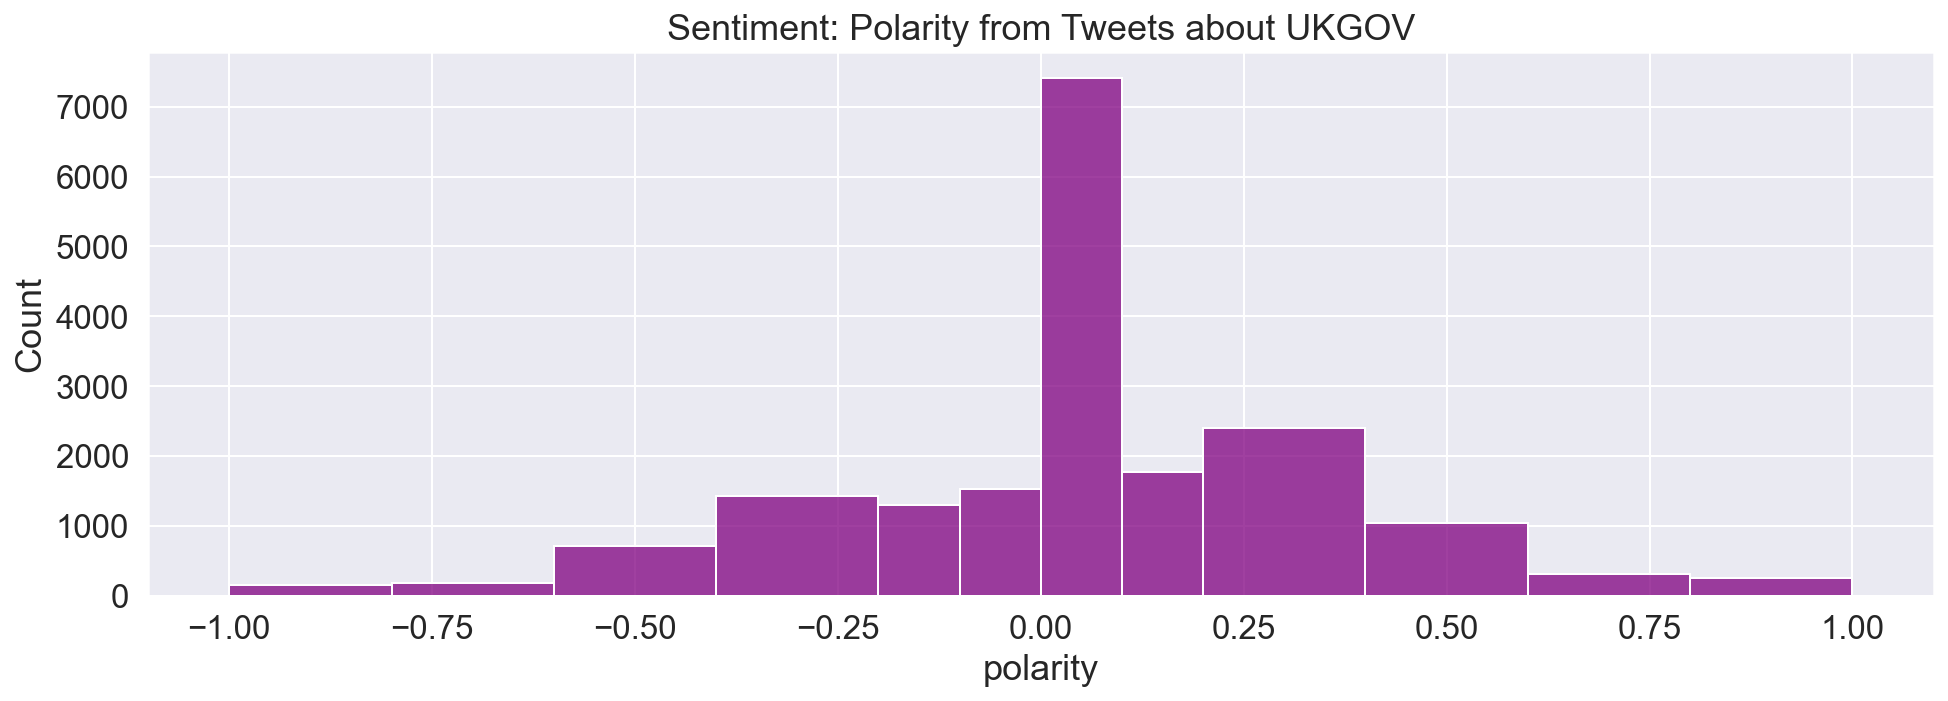

In [449]:
#call styles for plots
styles();

#histogram for polarity
sns.histplot(data=df, x="polarity", bins=[-1,-0.8, -0.6, -0.4, -0.2,-0.1, 0, 0.1, 0.2, 0.4, 0.6, 0.8,1], color="purple");

plt.title("Sentiment: Polarity from Tweets about UKGOV");
plt.show();

There is a lot of sentiment which is neutral. 

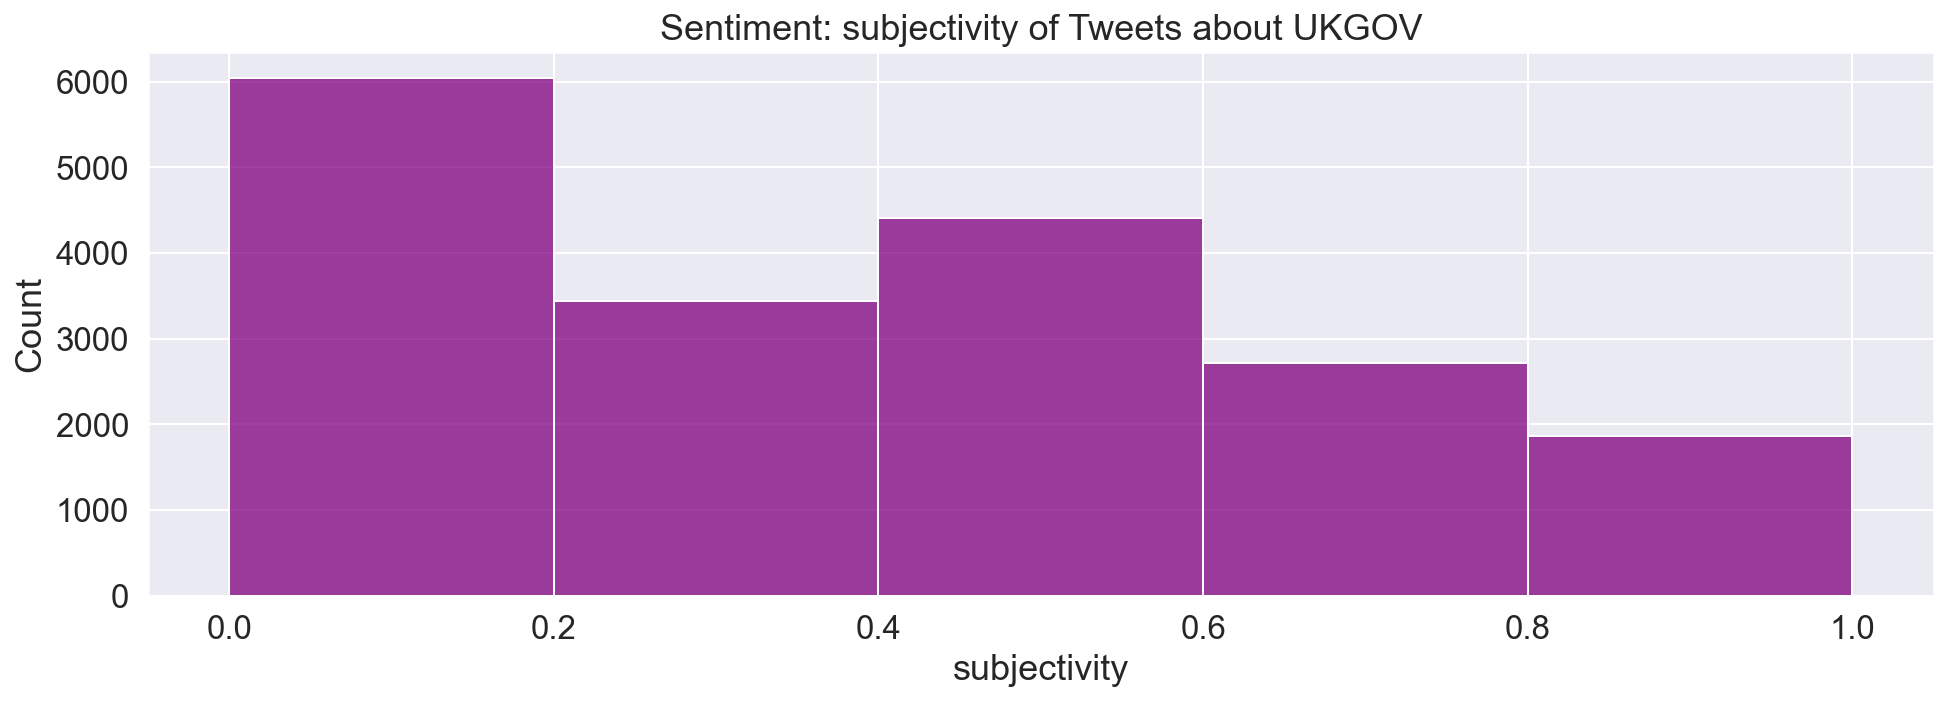

In [280]:
#call styles for plots
styles();

#histogram for polarity
sns.histplot(data=df, x="subjectivity", bins=[0, 0.2, 0.4, 0.6,0.8, 1], color="purple");

plt.title("Sentiment: subjectivity of Tweets about UKGOV");

plt.show();

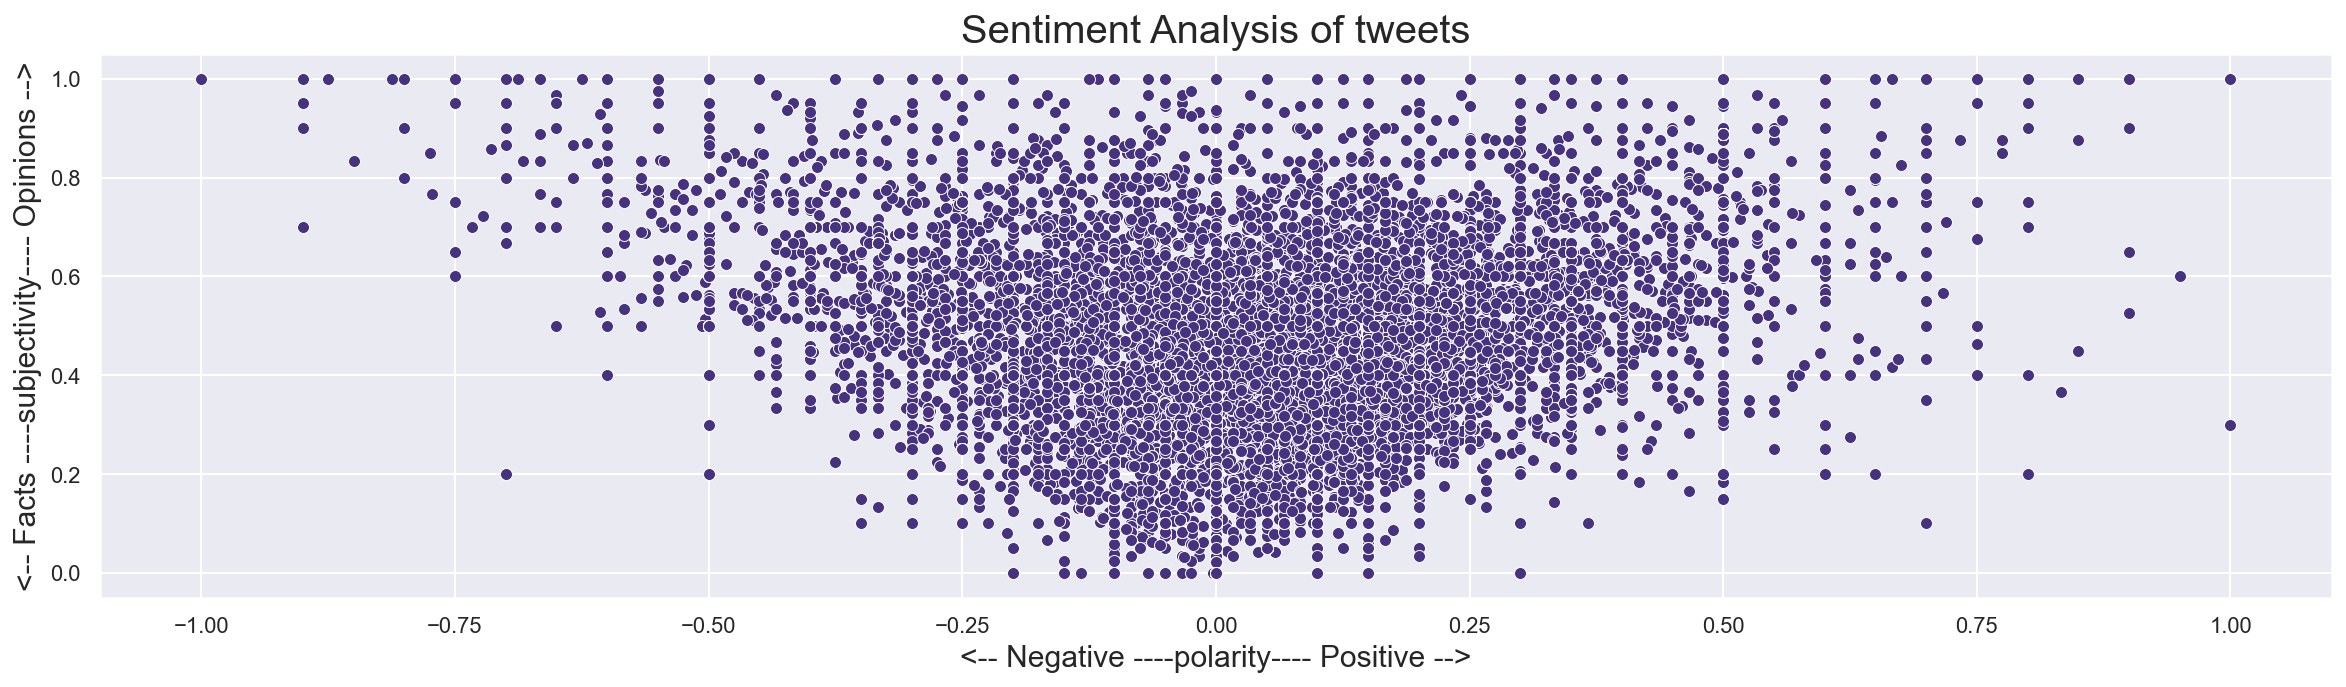

In [281]:
#set to seaborn
sns.set()
#palette="viridis"
sns.set_palette('viridis');
#plot size
plt.figure(figsize=(20, 5));  

sns.scatterplot(data=df, x="polarity", y="subjectivity")

plt.title("Sentiment Analysis of tweets", fontsize=20);
plt.xlabel('<-- Negative ----polarity---- Positive -->', fontsize=15);
plt.ylabel('<-- Facts ----subjectivity---- Opinions -->', fontsize=15);

plt.show();

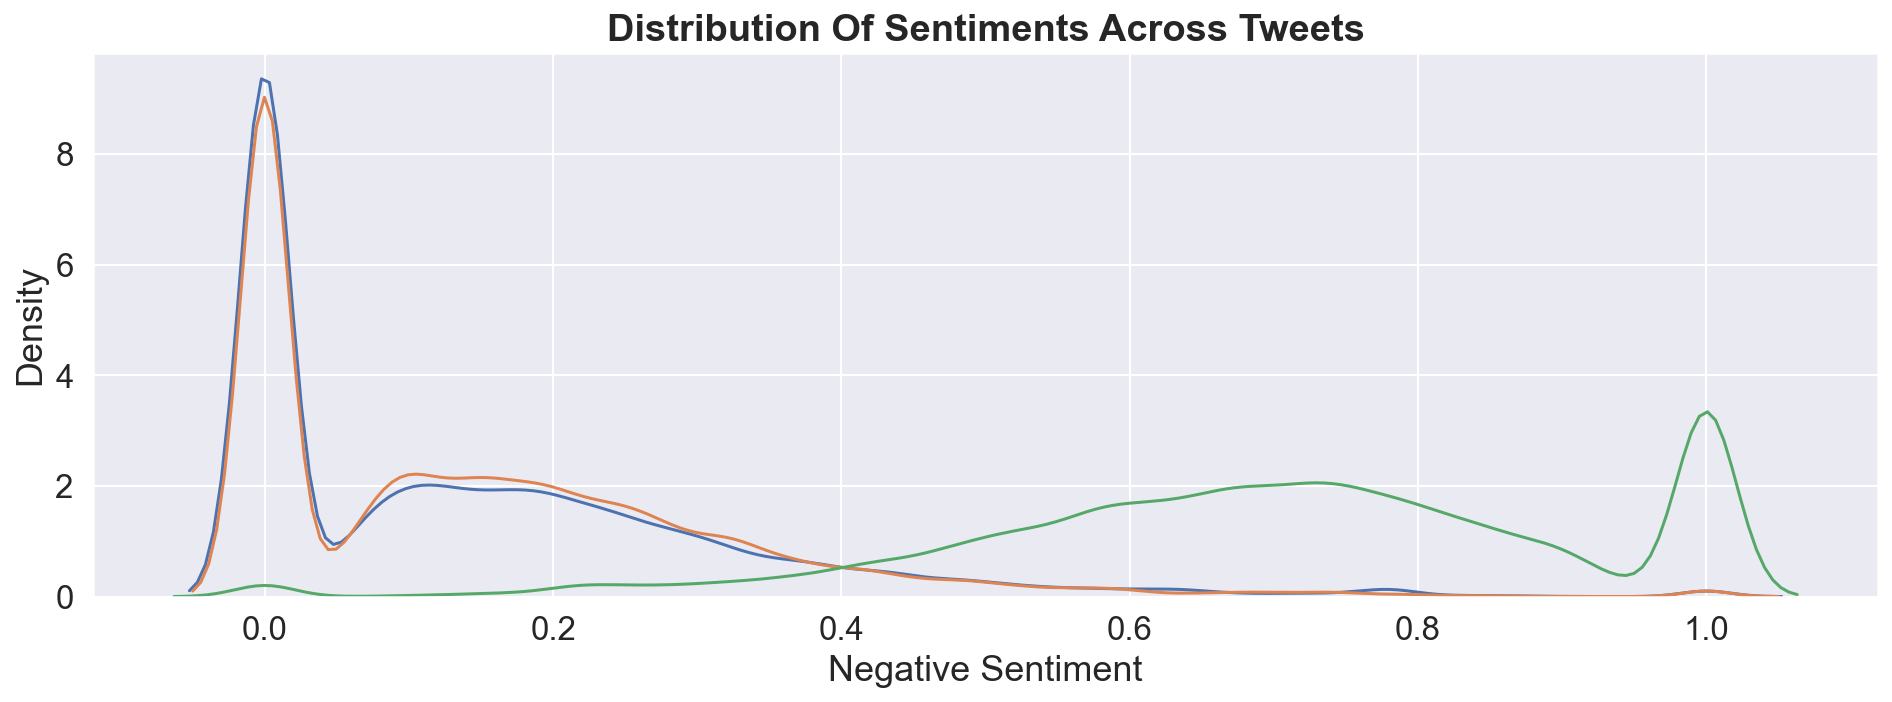

In [282]:
#call styles for plots
styles();

plt.title('Distribution Of Sentiments Across Tweets',fontsize=19,fontweight='bold');
sns.kdeplot(df['Negative Sentiment'],bw=0.1);
sns.kdeplot(df['Positive Sentiment'],bw=0.1);
sns.kdeplot(df['Neutral Sentiment'],bw=0.1);

<AxesSubplot:xlabel='Date', ylabel='Positive Sentiment'>

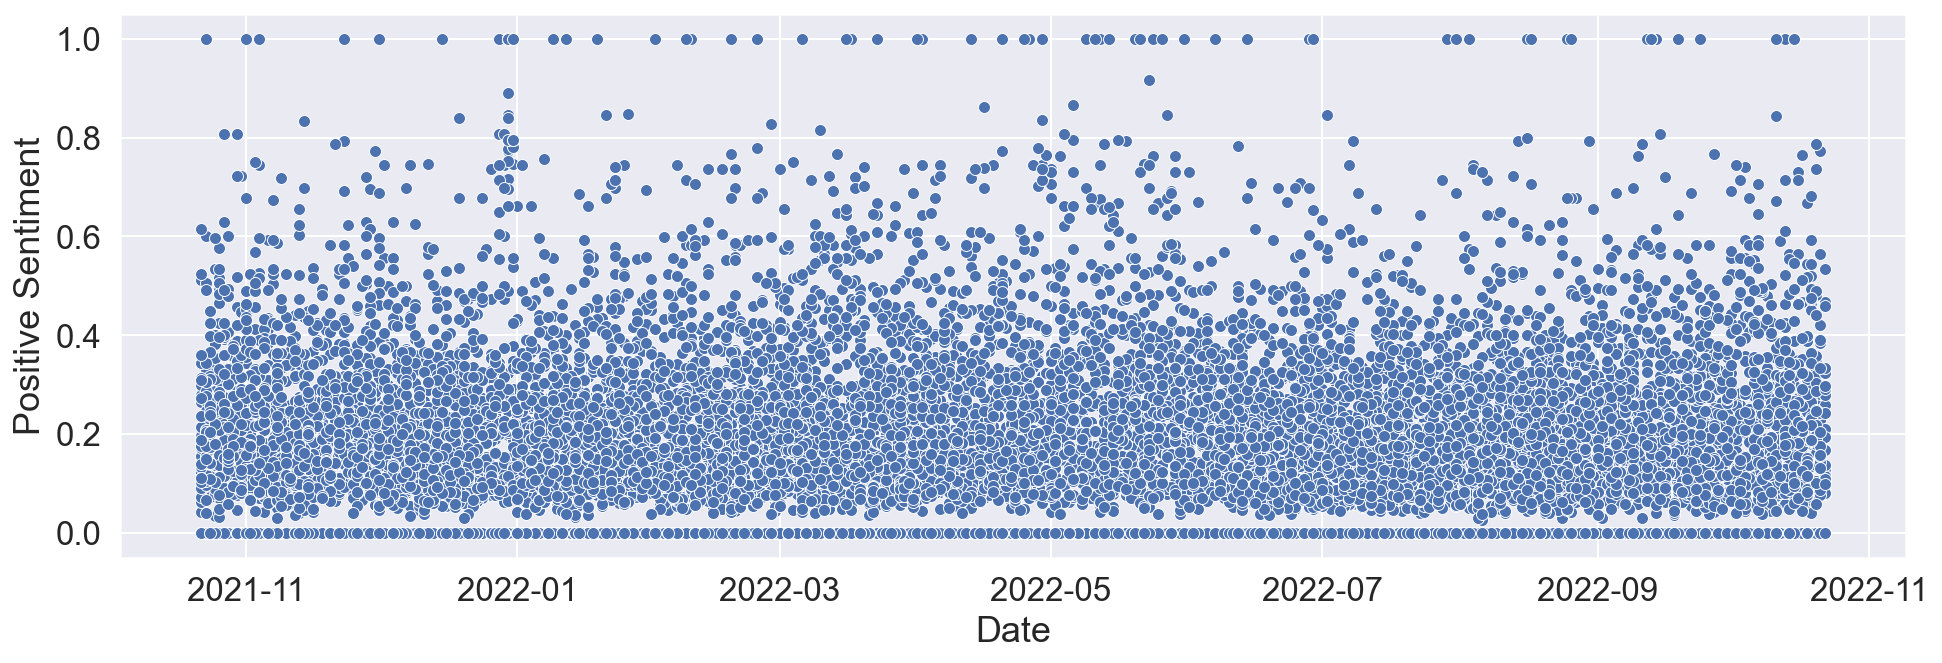

In [283]:
styles();
sns.scatterplot(x=df['Date'], y=df['Positive Sentiment'])

In [284]:
#pip install wordcloud

In [285]:
##Wordcloud Modules
from wordcloud import WordCloud 

In [52]:
def wc(data,bgcolor): # word cloud
    plt.figure(figsize=(10,10))
    wc=WordCloud(background_color=bgcolor,max_words=100, min_word_length=4, contour_width=3, contour_color='viridis')
    wc.generate(" ".join(data)) 
    plt.imshow(wc)
    plt.axis("off")

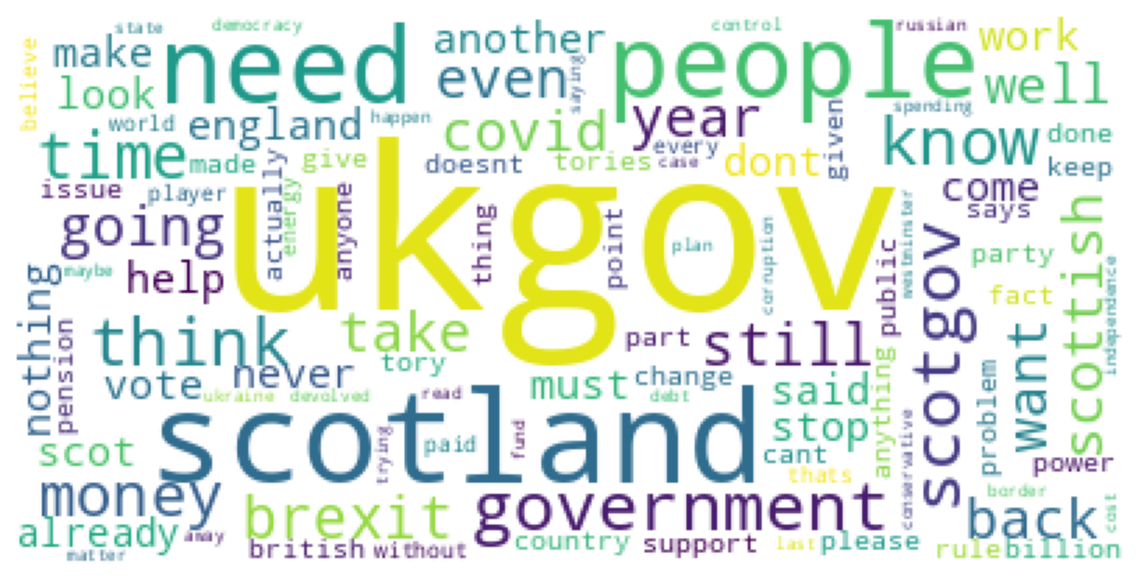

In [286]:
# neutral sentiment wordcloud
wc(df[df.polarity==0.0].tweet_clean, 'white')

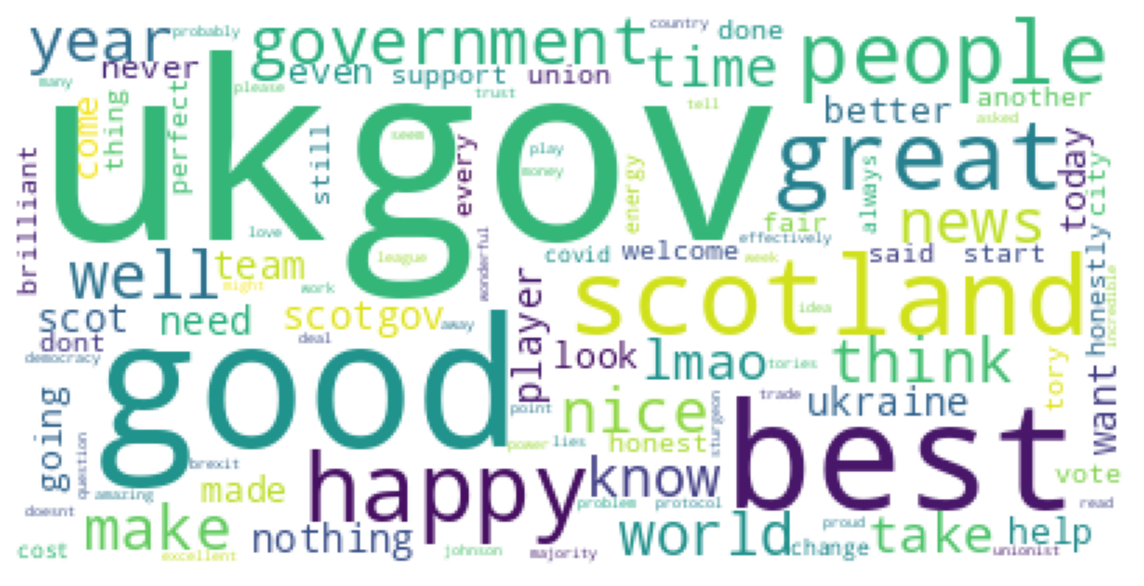

In [288]:
# positive sentiment wordcloud
wc(df[df.polarity>.55].tweet_clean, 'white')

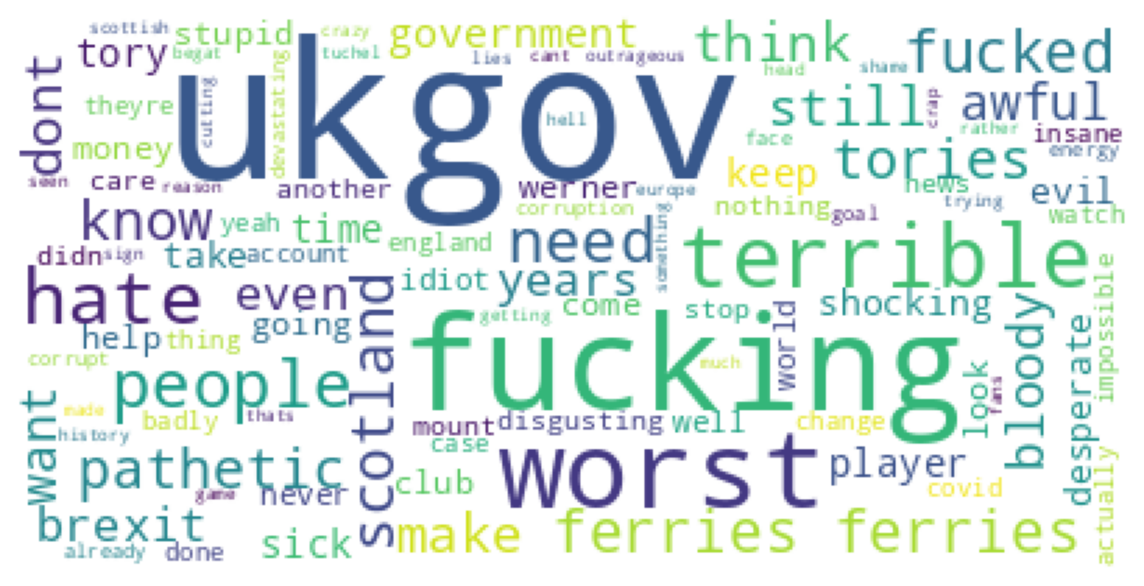

In [289]:
# negative sentiment wordcloud
wc(df[df.polarity<-.55].tweet_clean, 'white')

# Document term matrix

In [290]:
# We are going to create a document-term matrix using CountVectorizer, and exclude common English stop words

from sklearn.feature_extraction.text import CountVectorizer

# create a count vectorizer object
cv = CountVectorizer(stop_words="english")

# fit the count vectorizer using the text data
data_cv = cv.fit_transform(df['tweet_clean'])
data_dtm =pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())

# Pickle it for later use
import pickle
pickle.dump(cv, open("../data/cv_stop.pkl", "wb"))

data_dtm

aa  aampe  aanes  aare  aas  ab  aback  abandon  abandoned  abandoning  \
0       0      0      0     0    0   0      0        0          0           0   
1       0      0      0     0    0   0      0        0          0           0   
2       0      0      0     0    0   0      0        0          0           0   
3       0      0      0     0    0   0      0        0          0           0   
4       0      0      0     0    0   0      0        0          0           0   
...    ..    ...    ...   ...  ...  ..    ...      ...        ...         ...   
18476   0      0      0     0    0   0      0        0          0           0   
18477   0      0      0     0    0   0      0        0          0           0   
18478   0      0      0     0    0   0      0        0          0           0   
18479   0      0      0     0    0   0      0        0          0           0   
18480   0      0      0     0    0   0      0        0          0           0   

       ...  zoning  zoo  zoological  zoom  zoomers  zouma  zubair  ánd  \
0      ...       0    0           0     0        0      0       0    0   
1      ...       0    0           0     0        0      0       0    0   
2      ...       0    0           0     0        0      0       0    0   
3      ...       0    0           0     0        0      0       0    0   
4      ...       0    0           0     0        0      0       0    0   
...    ...     ...  ...         ...   ...      ...    ...     ...  ...   
18476  ...       0    0           0     0        0      0       0    0   
18477  ...       0    0           0     0        0      0       0    0   
18478  ...       0    0           0     0        0      0       0    0   
18479  ...       0    0           0     0        0      0       0    0   
18480  ...       0    0           0     0        0      0       0    0   

       çareally  پاکستانزندہباد  
0             0               0  
1             0               0  
2             0               0  
3             0               0  
4             0               0  
...         ...             ...  
18476         0               0  
18477         0               0  
18478         0               0  
18479         0               0  
18480         0               0  

[18481 rows x 33996 columns]

In [291]:
#Gensism Python framework for fast Vector Space Modelling
from gensim import matutils, models
#ndustrial-strength Natural Language Processing (NLP) in Python
import scipy.sparse

## Topic modelling

In [292]:
# One of the required inputs is a term-document matrix
data_dtm = data_dtm.transpose()
data_dtm.head()

0      1      2      3      4      5      6      7      8      9      \
aa         0      0      0      0      0      0      0      0      0      0   
aampe      0      0      0      0      0      0      0      0      0      0   
aanes      0      0      0      0      0      0      0      0      0      0   
aare       0      0      0      0      0      0      0      0      0      0   
aas        0      0      0      0      0      0      0      0      0      0   

       ...  18471  18472  18473  18474  18475  18476  18477  18478  18479  \
aa     ...      0      0      0      0      0      0      0      0      0   
aampe  ...      0      0      0      0      0      0      0      0      0   
aanes  ...      0      0      0      0      0      0      0      0      0   
aare   ...      0      0      0      0      0      0      0      0      0   
aas    ...      0      0      0      0      0      0      0      0      0   

       18480  
aa         0  
aampe      0  
aanes      0  
aare       0  
aas        0  

[5 rows x 18481 columns]

In [293]:
# turn term matrix into a sparse matrix
sparse_counts = scipy.sparse.csr_matrix(data_dtm)
#Convert a Scipy.sparse vector into the Gensim bag-of-words format
corpus = matutils.Sparse2Corpus(sparse_counts)

In [294]:
# collect the vocabulary items used in the count vectorizer
id2word = dict((v, k) for k, v in cv.vocabulary_.items())

In [295]:
# Train the model on the corpus.
lda = models.LdaModel(corpus=corpus, id2word=id2word, num_topics=2, passes=10)
lda.print_topics()

[(0,
  '0.023*"ukgov" + 0.007*"uk" + 0.006*"amp" + 0.005*"tax" + 0.004*"energy" + 0.004*"pay" + 0.004*"need" + 0.004*"like" + 0.003*"people" + 0.003*"ve"'),
 (1,
  '0.057*"ukgov" + 0.010*"amp" + 0.009*"uk" + 0.009*"scotland" + 0.005*"people" + 0.004*"brexit" + 0.004*"scotgov" + 0.004*"government" + 0.004*"like" + 0.003*"dont"')]

In [296]:
lda = models.LdaModel(corpus=corpus, id2word=id2word, num_topics=3, passes=10)
lda.print_topics()

[(0,
  '0.026*"ukgov" + 0.010*"amp" + 0.003*"uk" + 0.002*"corrupt" + 0.002*"brexit" + 0.002*"players" + 0.002*"government" + 0.002*"wanted" + 0.002*"rail" + 0.002*"party"'),
 (1,
  '0.053*"ukgov" + 0.013*"uk" + 0.011*"scotland" + 0.010*"amp" + 0.006*"money" + 0.005*"scotgov" + 0.005*"eu" + 0.004*"pay" + 0.004*"tax" + 0.004*"energy"'),
 (2,
  '0.047*"ukgov" + 0.007*"amp" + 0.007*"people" + 0.006*"like" + 0.006*"uk" + 0.004*"think" + 0.004*"time" + 0.004*"good" + 0.004*"know" + 0.004*"need"')]

In [297]:
# LDA for num_topics = 4
lda = models.LdaModel(corpus=corpus, id2word=id2word, num_topics=4, passes=10)
lda.print_topics()

[(0,
  '0.041*"ukgov" + 0.004*"uk" + 0.003*"got" + 0.003*"brexit" + 0.003*"today" + 0.003*"bbc" + 0.002*"people" + 0.002*"court" + 0.002*"makes" + 0.002*"argument"'),
 (1,
  '0.007*"ukgov" + 0.007*"shit" + 0.007*"fuck" + 0.004*"man" + 0.004*"club" + 0.003*"chelsea" + 0.003*"fucking" + 0.003*"like" + 0.003*"rights" + 0.003*"need"'),
 (2,
  '0.063*"ukgov" + 0.014*"uk" + 0.014*"amp" + 0.011*"scotland" + 0.006*"people" + 0.005*"eu" + 0.005*"scotgov" + 0.005*"money" + 0.004*"like" + 0.004*"dont"'),
 (3,
  '0.023*"ukgov" + 0.007*"people" + 0.007*"amp" + 0.005*"like" + 0.004*"know" + 0.004*"think" + 0.003*"war" + 0.003*"refugees" + 0.003*"time" + 0.003*"need"')]

In [298]:
# LDA for num_topics = 5
lda = models.LdaModel(corpus=corpus, id2word=id2word, num_topics=5, passes=10)
lda.print_topics()

[(0,
  '0.037*"ukgov" + 0.012*"amp" + 0.011*"uk" + 0.011*"eu" + 0.007*"brexit" + 0.006*"ni" + 0.005*"border" + 0.005*"people" + 0.004*"new" + 0.004*"ireland"'),
 (1,
  '0.069*"ukgov" + 0.012*"uk" + 0.012*"amp" + 0.012*"scotland" + 0.005*"like" + 0.005*"people" + 0.005*"know" + 0.005*"scotgov" + 0.005*"think" + 0.005*"dont"'),
 (2,
  '0.005*"liverpool" + 0.004*"team" + 0.004*"league" + 0.004*"vaccine" + 0.004*"win" + 0.003*"final" + 0.003*"lol" + 0.003*"man" + 0.003*"tuchel" + 0.003*"shouldn"'),
 (3,
  '0.008*"fuck" + 0.007*"shit" + 0.006*"like" + 0.006*"ve" + 0.006*"fucking" + 0.006*"man" + 0.005*"club" + 0.005*"good" + 0.004*"really" + 0.004*"chelsea"'),
 (4,
  '0.042*"ukgov" + 0.008*"energy" + 0.008*"amp" + 0.007*"uk" + 0.007*"tax" + 0.006*"people" + 0.004*"brexit" + 0.004*"oil" + 0.004*"pay" + 0.004*"companies"')]

# Topic Modeling - Attempt #2 (Nouns Only)¶

In [299]:
# Let's create a function to pull out nouns from a string of text
from nltk import word_tokenize, pos_tag

def nouns(text):
    '''Given a string of text, tokenize the text and pull out only the nouns.'''
    is_noun = lambda pos: pos[:2] == 'NN'
    tokenized = word_tokenize(text)
    all_nouns = [word for (word, pos) in pos_tag(tokenized) if is_noun(pos)] 
    return ' '.join(all_nouns)

In [300]:
# Apply the nouns function to the transcripts to filter only on nouns
df['data_nouns'] = pd.DataFrame(df.tweet_clean.apply(nouns))
df.head(5)

Datetime             Tweet ID  \
0 2021-10-22 10:08:21+00:00  1451490603766886402   
1 2021-10-26 16:29:15+00:00  1453036010149978115   
2 2021-10-29 23:23:59+00:00  1454227542680948738   
3 2021-11-01 14:35:47+00:00  1455181783377629197   
4 2021-11-02 18:57:34+00:00  1455610051608162312   

                                                Text         Username  \
0  Missed our recent webinar with partners Social...        AdviceGov   
1  @DavidPa80122564 I think the ukgov are afraid ...  gylesnamopaleen   
2  @TerrorismPolice The irony...#UKGov know most ...        KSmth2000   
3  The UKGov report implies any therapy which isn...    luluskip2malu   
4  @flodwyns @BlokeOnWheels @SandraDunn1955 The o...  jimmerfaestoney   

   retweetCount  likeCount                                           hashtags  \
0             0          0  ['SocialValue', 'Gov', 'Procurement', 'PublicS...   
1             0          1                                         ['brexit']   
2             0          0         ['UKGov', 'UKGovAndTheirIllegalProxywars']   
3             1          1                                                      
4             0          0                                                      

         Date  Month  Year  ...  stopwords  hashtag_count  \
0  2021-10-22     10  2021  ...         10              5   
1  2021-10-26     10  2021  ...         19              0   
2  2021-10-29     10  2021  ...          7              1   
3  2021-11-01     11  2021  ...          9              0   
4  2021-11-02     11  2021  ...         18              0   

                                         tweet_clean  polarity  subjectivity  \
0  missed recent webinar partners social value bu...  0.141667      0.220833   
1  think ukgov afraid people wont able cope wonde...  0.193750      0.725000   
2  ironyukgov know ukgov allowed many back countr...  0.250000      0.250000   
3  ukgov report implies therapy isnt “affirming” ...  0.000000      0.400000   
4  organisation ukgov led inside blue zone whole ...  0.150000      0.277778   

   Positive Sentiment  Neutral Sentiment  Negative Sentiment  compound  \
0            0.297001           0.618001            0.085001  0.670501   
1            0.115001           0.752001            0.133001 -0.102199   
2            0.000001           1.000001            0.000001  0.000001   
3            0.000001           0.811001            0.189001 -0.680799   
4            0.116001           0.884001            0.000001  0.440401   

                                          data_nouns  
0  partners value business lots value procurement...  
1  people cope sunlit uplands extension brexit ea...  
2    ironyukgov countryukgovandtheirillegalproxywars  
3  report implies “ doesnt access transition heal...  
4  organisation ukgov zone area responsibility ro...  

[5 rows x 27 columns]

In [301]:
pd.set_option('display.max_colwidth', None)

df_subset = df[["Text", "hashtags", "tweet_clean", "data_nouns"]]
df_subset.head() 

Text  \
0                                                              Missed our recent webinar with partners Social Value Business? We covered lots about Social Value and how the procurement landscape has changed (for the better) because of it. https://t.co/6XAa0MkG7i #SocialValue #Gov #Procurement #PublicSector #UKGov   
1                                                                  @DavidPa80122564 I think the ukgov are afraid people won't be able to cope with how wonderful the sunlit uplands will be and begged the EU for an extension to the "#brexit easement" period.\n\nIt was due to end in July 2021 https://t.co/03RoQfFVGt   
2                                                                                                                                                                           @TerrorismPolice The irony...#UKGov know most of them, being UKGov allowed many of them back into the country.\n#UKGovAndTheirIllegalProxywars   
3                                                   The UKGov report implies any therapy which isnt “affirming” &amp; which doesnt provide access to transition related healthcare is “gender identity conversion therapy” &amp; ignores emerging evidence that “affirming” has in fact caused harm to detransitioners /14   
4  @flodwyns @BlokeOnWheels @SandraDunn1955 The organisation of COP26 is UKGov led. Inside the BLUE zone itself, the whole area is responsibility of the UK and UN.\n\nUnfortunately, ScotGov has no official role at COP or in organising, altho our First Minister has been welcoming delegates to Scotland and Glasgow.   

                                                         hashtags  \
0  ['SocialValue', 'Gov', 'Procurement', 'PublicSector', 'UKGov']   
1                                                      ['brexit']   
2                      ['UKGov', 'UKGovAndTheirIllegalProxywars']   
3                                                                   
4                                                                   

                                                                                                                                                                                                             tweet_clean  \
0                                                     missed recent webinar partners social value business covered lots social value procurement landscape changed better socialvalue gov procurement publicsector ukgov   
1                                                                                            think ukgov afraid people wont able cope wonderful sunlit uplands begged eu extension brexit easement periodit due end july   
2                                                                                                                                           ironyukgov know ukgov allowed many back countryukgovandtheirillegalproxywars   
3  ukgov report implies therapy isnt “affirming” amp doesnt provide access transition related healthcare “gender identity conversion therapy” amp ignores emerging evidence “affirming” fact caused harm detransitioners   
4                                    organisation ukgov led inside blue zone whole area responsibility uk ununfortunately scotgov official role cop organising altho first minister welcoming delegates scotland glasgow   

                                                                                                                                   data_nouns  
0                                     partners value business lots value procurement landscape socialvalue gov procurement publicsector ukgov  
1                                                                      people cope sunlit uplands extension brexit easement periodit end july  
2                                                                                             ironyukgov countryukgovandtheirillegalproxywars  
3  report implies “ doesnt access transition healthcare gender identity conversion therap

In [302]:
# Create a new document-term matrix using only nouns
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer

# Re-add the additional stop words since we are recreating the document-term matrix
add_stop_words = ['like', 'im', 'know', 'just', 'dont', 'thats', 'right', 'people',
                  'youre', 'got', 'gonna', 'time', 'think', 'yeah', 'said', 'amp', 'ukgov']
stop_words = text.ENGLISH_STOP_WORDS.union(add_stop_words)

# Recreate a document-term matrix with only nouns
cvn = CountVectorizer(stop_words=stop_words)
data_cvn = cvn.fit_transform(df.data_nouns)
data_dtmn = pd.DataFrame(data_cvn.toarray(), columns=cvn.get_feature_names())

data_dtmn

aampe  aanes  aas  abandon  abandonment  abandons  abatingnot  abd  \
0          0      0    0        0            0         0           0    0   
1          0      0    0        0            0         0           0    0   
2          0      0    0        0            0         0           0    0   
3          0      0    0        0            0         0           0    0   
4          0      0    0        0            0         0           0    0   
...      ...    ...  ...      ...          ...       ...         ...  ...   
18476      0      0    0        0            0         0           0    0   
18477      0      0    0        0            0         0           0    0   
18478      0      0    0        0            0         0           0    0   
18479      0      0    0        0            0         0           0    0   
18480      0      0    0        0            0         0           0    0   

       abdel  abdicatesconstitution  ...  zombie  zone  zoneits  zones  \
0          0                      0  ...       0     0        0      0   
1          0                      0  ...       0     0        0      0   
2          0                      0  ...       0     0        0      0   
3          0                      0  ...       0     0        0      0   
4          0                      0  ...       0     1        0      0   
...      ...                    ...  ...     ...   ...      ...    ...   
18476      0                      0  ...       0     0        0      0   
18477      0                      0  ...       0     0        0      0   
18478      0                      0  ...       0     0        0      0   
18479      0                      0  ...       0     0        0      0   
18480      0                      0  ...       0     0        0      0   

       zonestbf  zoo  zoom  zoomers  zouma  zubair  
0             0    0     0        0      0       0  
1             0    0     0        0      0       0  
2             0    0     0        0      0       0  
3             0    0     0        0      0       0  
4             0    0     0        0      0       0  
...         ...  ...   ...      ...    ...     ...  
18476         0    0     0        0      0       0  
18477         0    0     0        0      0       0  
18478         0    0     0        0      0       0  
18479         0    0     0        0      0       0  
18480         0    0     0        0      0       0  

[18481 rows x 20913 columns]

In [303]:
# Create the gensim corpus
corpusn = matutils.Sparse2Corpus(scipy.sparse.csr_matrix(data_dtmn.transpose()))

# Create the vocabulary dictionary
id2wordn = dict((v, k) for k, v in cvn.vocabulary_.items())

In [304]:
# Let's start with 2 topics
ldan = models.LdaModel(corpus=corpusn, num_topics=2, id2word=id2wordn, passes=10)
ldan.print_topics()

[(0,
  '0.013*"scotland" + 0.008*"money" + 0.008*"brexit" + 0.007*"years" + 0.005*"tories" + 0.005*"tax" + 0.005*"scotgov" + 0.005*"eu" + 0.004*"independence" + 0.004*"scots"'),
 (1,
  '0.011*"government" + 0.007*"energy" + 0.004*"man" + 0.004*"companies" + 0.003*"help" + 0.003*"media" + 0.003*"work" + 0.003*"news" + 0.003*"oil" + 0.003*"corruption"')]

In [305]:
# Let's try topics = 3
ldan = models.LdaModel(corpus=corpusn, num_topics=3, id2word=id2wordn, passes=10)
ldan.print_topics()

[(0,
  '0.008*"eu" + 0.007*"brexit" + 0.006*"government" + 0.005*"country" + 0.005*"war" + 0.005*"party" + 0.005*"years" + 0.005*"corruption" + 0.005*"tories" + 0.004*"law"'),
 (1,
  '0.015*"money" + 0.007*"pay" + 0.007*"scotland" + 0.007*"don" + 0.006*"problem" + 0.006*"man" + 0.006*"debt" + 0.005*"tax" + 0.005*"spending" + 0.005*"oil"'),
 (2,
  '0.016*"scotland" + 0.009*"energy" + 0.009*"government" + 0.007*"independence" + 0.006*"help" + 0.005*"vote" + 0.005*"cost" + 0.005*"snp" + 0.005*"support" + 0.005*"democracy"')]

In [306]:
# Let's try 4 topics
ldan = models.LdaModel(corpus=corpusn, num_topics=4, id2word=id2wordn, passes=10)
ldan.print_topics()

[(0,
  '0.008*"man" + 0.005*"data" + 0.005*"don" + 0.005*"tests" + 0.004*"player" + 0.004*"fuck" + 0.004*"game" + 0.004*"season" + 0.004*"list" + 0.004*"conservatives"'),
 (1,
  '0.010*"eu" + 0.010*"brexit" + 0.007*"independence" + 0.006*"deal" + 0.006*"country" + 0.006*"vote" + 0.006*"state" + 0.006*"democracy" + 0.006*"union" + 0.006*"government"'),
 (2,
  '0.016*"scotland" + 0.008*"years" + 0.006*"law" + 0.005*"scots" + 0.005*"problem" + 0.004*"majority" + 0.004*"debt" + 0.004*"fact" + 0.004*"brexit" + 0.004*"england"'),
 (3,
  '0.016*"money" + 0.010*"tax" + 0.009*"energy" + 0.009*"scotland" + 0.008*"government" + 0.007*"pay" + 0.007*"year" + 0.005*"cost" + 0.005*"companies" + 0.005*"help"')]

## Topic Modeling - Attempt #3 (Nouns and Adjectives)

In [310]:
# Let's create a function to pull out nouns from a string of text
def nouns_adj(text):
    '''Given a string of text, tokenize the text and pull out only the nouns and adjectives.'''
    is_noun_adj = lambda pos: pos[:2] == 'NN' or pos[:2] == 'JJ'
    tokenized = word_tokenize(text)
    nouns_adj = [word for (word, pos) in pos_tag(tokenized) if is_noun_adj(pos)] 
    return ' '.join(nouns_adj)

In [311]:
# Apply the nouns function to the transcripts to filter only on nouns
df['data_nouns_adj'] = pd.DataFrame(df.tweet_clean.apply(nouns_adj))

In [312]:
# Create a new document-term matrix using only nouns and adjectives, also remove common words with max_df
cvna = CountVectorizer(stop_words=stop_words, max_df=.8)
data_cvna = cvna.fit_transform(df.data_nouns_adj)
data_dtmna = pd.DataFrame(data_cvna.toarray(), columns=cvna.get_feature_names())


In [313]:
# Create the gensim corpus
corpusna = matutils.Sparse2Corpus(scipy.sparse.csr_matrix(data_dtmna.transpose()))

# Create the vocabulary dictionary
id2wordna = dict((v, k) for k, v in cvna.vocabulary_.items())

In [314]:
# Let's try 3 topics
ldana = models.LdaModel(corpus=corpusna, num_topics=3, id2word=id2wordna, passes=10)
ldana.print_topics()

[(0,
  '0.008*"uk" + 0.007*"brexit" + 0.005*"eu" + 0.005*"law" + 0.004*"vote" + 0.004*"party" + 0.004*"way" + 0.004*"corruption" + 0.004*"good" + 0.003*"fuck"'),
 (1,
  '0.006*"man" + 0.005*"good" + 0.004*"shit" + 0.004*"ve" + 0.003*"today" + 0.003*"club" + 0.003*"bad" + 0.003*"player" + 0.003*"chelsea" + 0.003*"worse"'),
 (2,
  '0.021*"uk" + 0.014*"scotland" + 0.007*"money" + 0.007*"scotgov" + 0.006*"government" + 0.006*"scottish" + 0.005*"tax" + 0.005*"energy" + 0.005*"snp" + 0.004*"scots"')]

In [315]:
# Let's try 4 topics
ldana = models.LdaModel(corpus=corpusna, num_topics=4, id2word=id2wordna, passes=10)
ldana.print_topics()

[(0,
  '0.015*"uk" + 0.005*"scotland" + 0.005*"snp" + 0.005*"british" + 0.005*"good" + 0.004*"ukraine" + 0.004*"pension" + 0.004*"government" + 0.004*"russian" + 0.003*"vote"'),
 (1,
  '0.016*"uk" + 0.010*"eu" + 0.009*"brexit" + 0.008*"scotland" + 0.005*"law" + 0.004*"ni" + 0.004*"border" + 0.004*"referendum" + 0.004*"independence" + 0.004*"deal"'),
 (2,
  '0.014*"uk" + 0.010*"money" + 0.010*"scotland" + 0.008*"tax" + 0.008*"energy" + 0.006*"scotgov" + 0.006*"government" + 0.005*"tory" + 0.005*"scottish" + 0.005*"year"'),
 (3,
  '0.007*"man" + 0.006*"fuck" + 0.005*"ve" + 0.005*"shit" + 0.004*"don" + 0.004*"corrupt" + 0.004*"isn" + 0.004*"city" + 0.004*"club" + 0.004*"player"')]

In [316]:
# Let's try 5 topics
ldana = models.LdaModel(corpus=corpusna, num_topics=5, id2word=id2wordna, passes=10)
ldana.print_topics()

[(0,
  '0.022*"uk" + 0.010*"eu" + 0.010*"brexit" + 0.007*"energy" + 0.006*"covid" + 0.005*"tax" + 0.005*"help" + 0.004*"crisis" + 0.004*"scotgov" + 0.003*"cost"'),
 (1,
  '0.006*"rights" + 0.005*"court" + 0.005*"uk" + 0.004*"country" + 0.004*"law" + 0.004*"government" + 0.004*"border" + 0.004*"human" + 0.003*"act" + 0.003*"way"'),
 (2,
  '0.021*"scotland" + 0.014*"uk" + 0.010*"money" + 0.009*"scottish" + 0.008*"snp" + 0.008*"scotgov" + 0.007*"government" + 0.006*"tory" + 0.006*"scots" + 0.005*"years"'),
 (3,
  '0.008*"uk" + 0.007*"good" + 0.005*"new" + 0.004*"city" + 0.004*"tests" + 0.004*"ukraine" + 0.004*"world" + 0.004*"war" + 0.004*"player" + 0.004*"ve"'),
 (4,
  '0.007*"man" + 0.006*"club" + 0.005*"chelsea" + 0.004*"players" + 0.004*"contracts" + 0.004*"need" + 0.003*"week" + 0.003*"way" + 0.003*"mount" + 0.003*"ukrainian"')]

In [317]:
# Let's try 5 topics
ldana = models.LdaModel(corpus=corpusna, num_topics=6, id2word=id2wordna, passes=10)
ldana.print_topics()

[(0,
  '0.028*"uk" + 0.010*"eu" + 0.006*"scotland" + 0.005*"government" + 0.005*"ukraine" + 0.004*"use" + 0.004*"brexit" + 0.004*"countries" + 0.004*"policy" + 0.004*"law"'),
 (1,
  '0.014*"brexit" + 0.009*"border" + 0.008*"rights" + 0.008*"eu" + 0.007*"ni" + 0.006*"protocol" + 0.006*"ireland" + 0.006*"uk" + 0.005*"human" + 0.004*"government"'),
 (2,
  '0.014*"scotland" + 0.013*"uk" + 0.009*"tory" + 0.007*"independence" + 0.007*"vote" + 0.006*"union" + 0.006*"democracy" + 0.006*"party" + 0.006*"scots" + 0.006*"scottish"'),
 (3,
  '0.010*"man" + 0.009*"fuck" + 0.009*"good" + 0.007*"ve" + 0.007*"shit" + 0.006*"city" + 0.006*"club" + 0.006*"don" + 0.005*"player" + 0.005*"chelsea"'),
 (4,
  '0.013*"energy" + 0.008*"money" + 0.007*"scotland" + 0.007*"companies" + 0.007*"tax" + 0.007*"uk" + 0.005*"crisis" + 0.005*"help" + 0.005*"country" + 0.005*"oil"'),
 (5,
  '0.012*"money" + 0.012*"uk" + 0.009*"scotgov" + 0.008*"years" + 0.007*"pay" + 0.006*"covid" + 0.006*"scotland" + 0.006*"spending" + 

## LDA Dash

In [442]:
#pip install pyLDAvis

In [327]:
import pyLDAvis.gensim_models
import pickle 
import pyLDAvis
# Visualize the topics
pyLDAvis.enable_notebook()

num_topics = 6 

LDAvis_data_filepath = os.path.join('./results/ldavis_prepared_'+str(num_topics))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim_models.prepare(ldana, corpus, id2word) # ldana - final model
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
    
pyLDAvis.save_html(LDAvis_prepared, './results/ldavis_prepared_'+ str(num_topics) +'.html')
LDAvis_prepared

AttributeError: 'dict' object has no attribute 'token2id'

# Sentiment changes over time

<Figure size 1152x360 with 0 Axes>

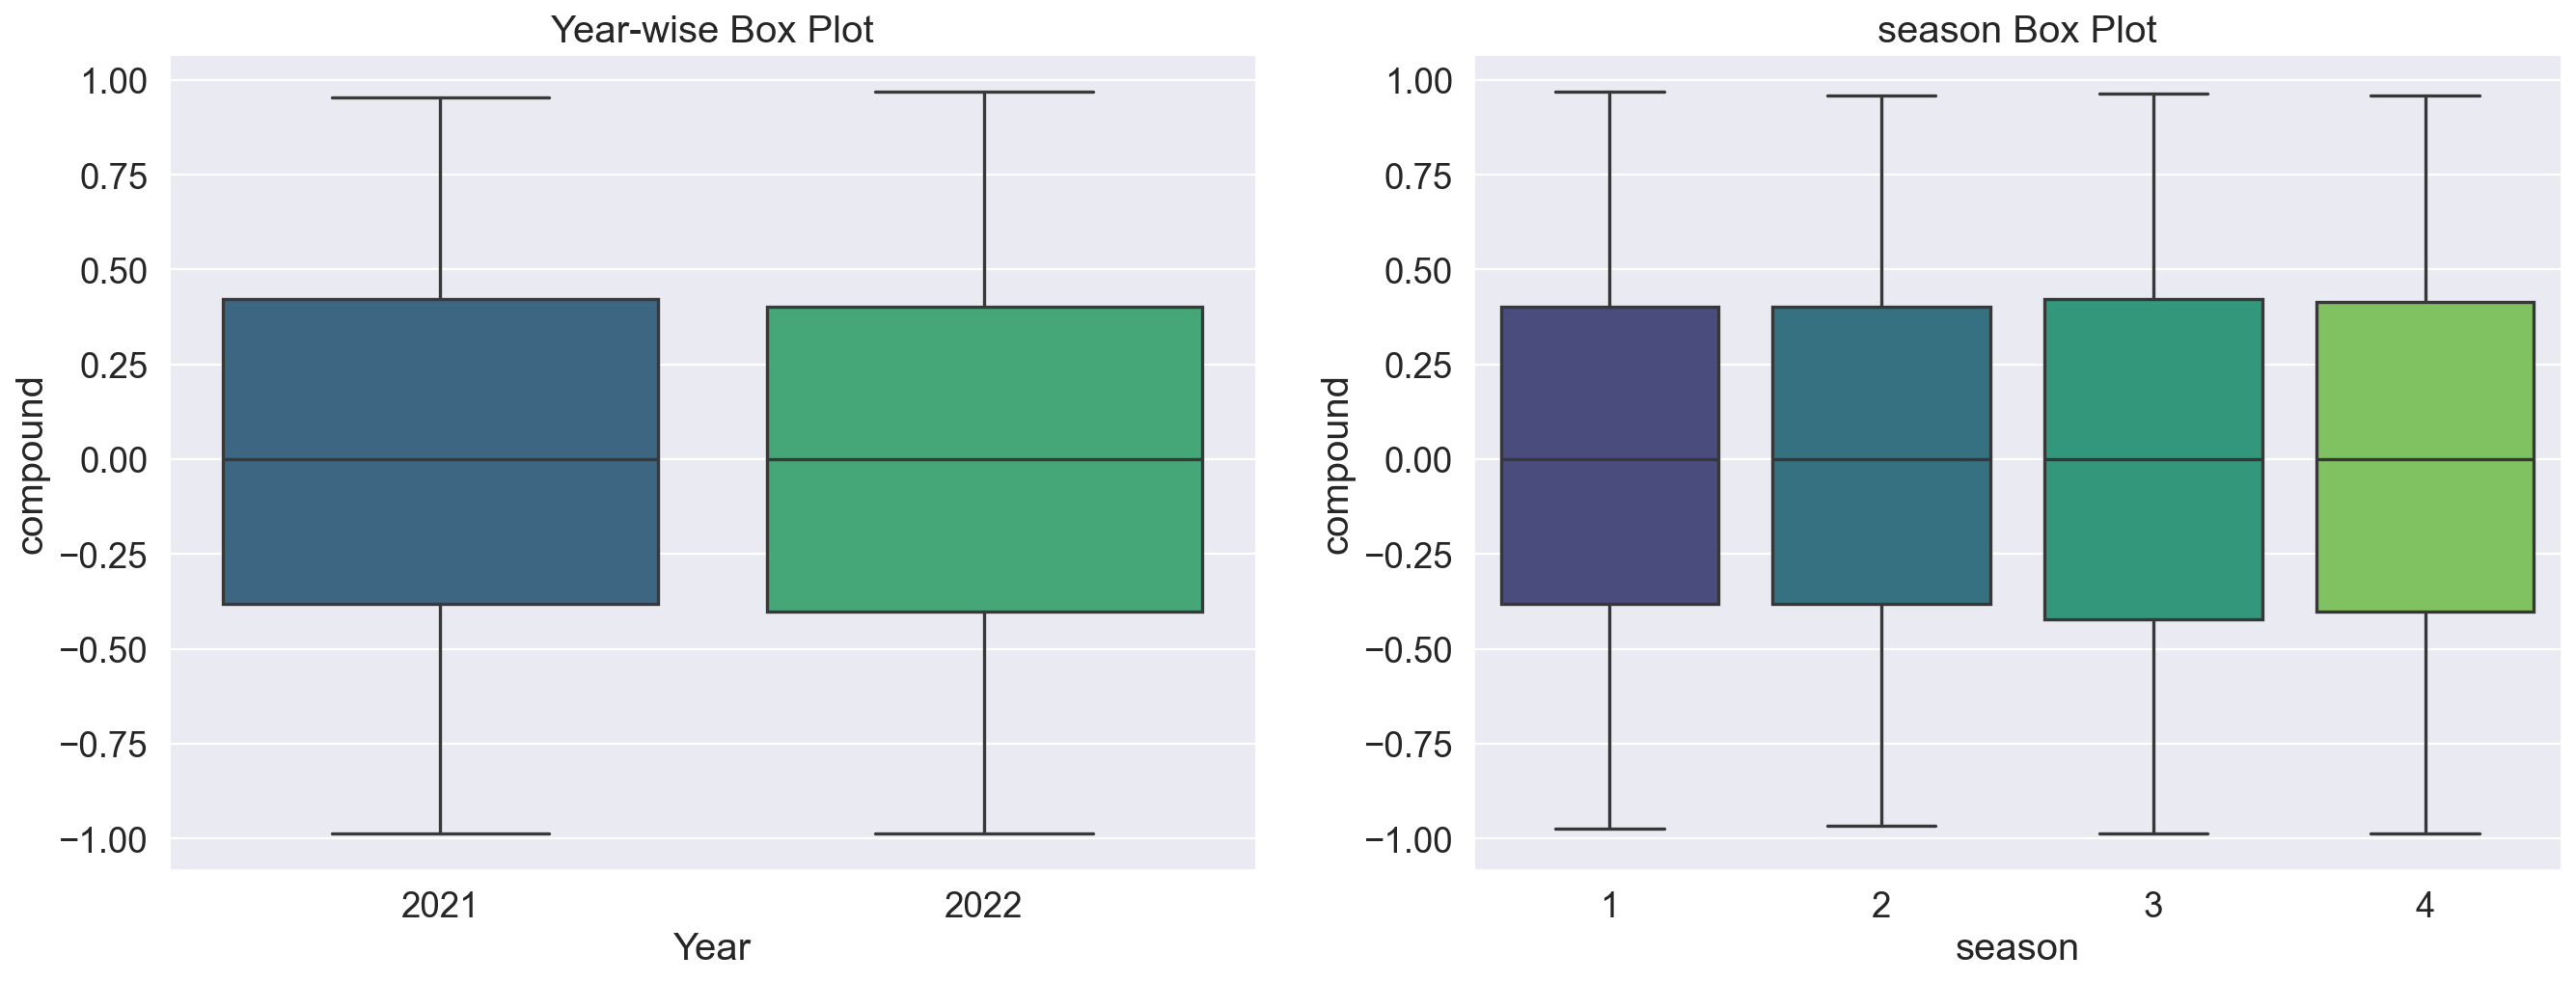

In [237]:
#call styles for plots
styles();
# Draw Plot
fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x='Year', y='compound', data=df, ax=axes[0], palette='viridis')
sns.boxplot(x='season', y='compound', data=df, ax=axes[1] , palette='viridis' )


# Set Title
axes[0].set_title('Year-wise Box Plot', fontsize=18); 
axes[1].set_title('season Box Plot', fontsize=18)


plt.show()

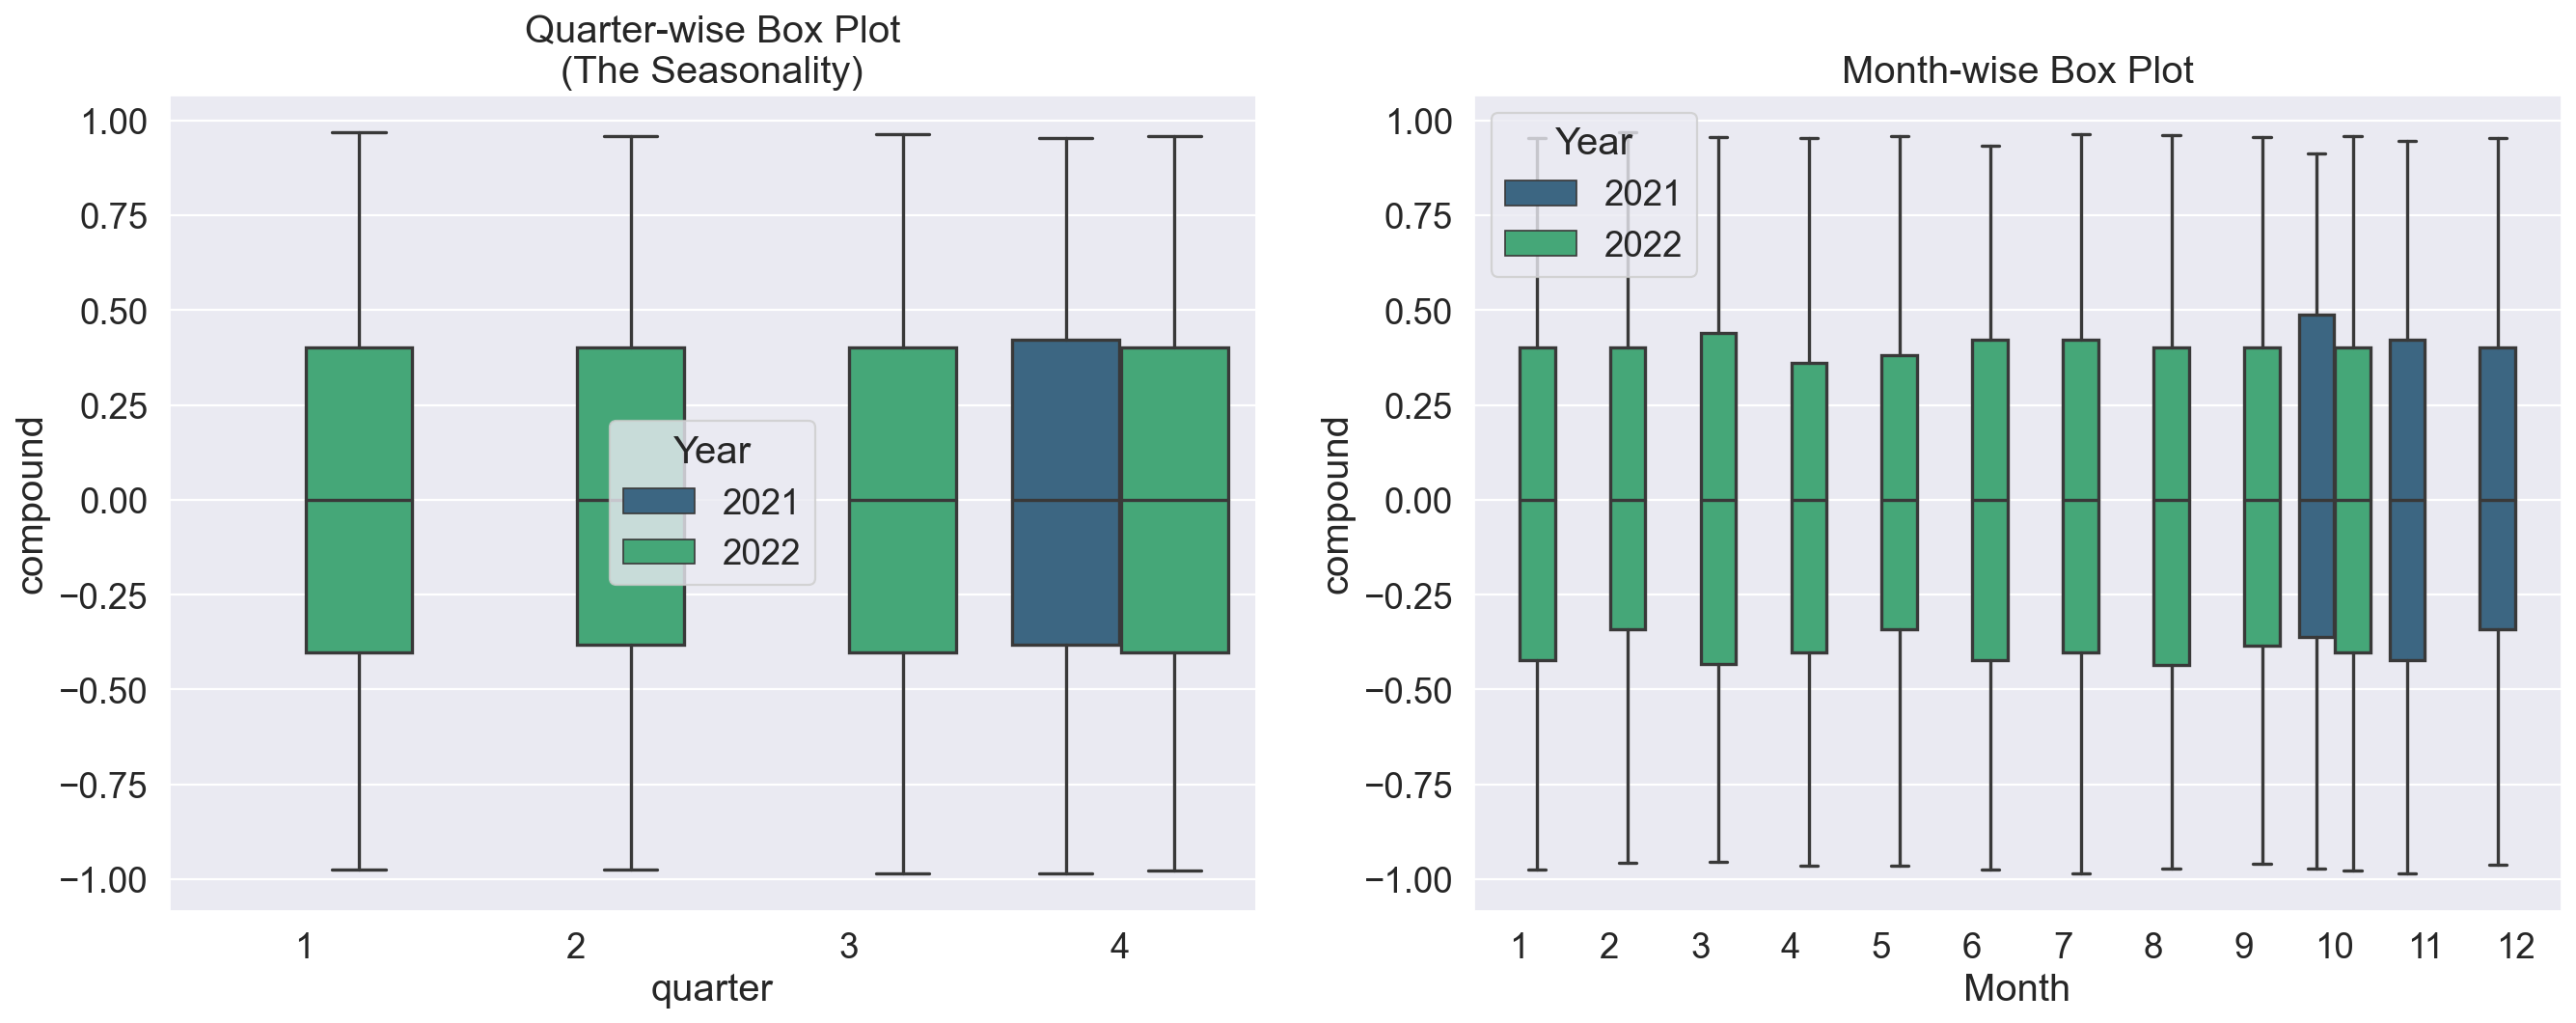

In [236]:
# Draw Plot
fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)


sns.boxplot(x='quarter', y='compound', data=df, ax=axes[0] , palette='viridis', hue="Year")
sns.boxplot(x='Month', y='compound', data=df, ax=axes[1], palette='viridis', hue="Year");


# Set Title
axes[0].set_title('Quarter-wise Box Plot\n(The Seasonality)', fontsize=18)
axes[1].set_title('Month-wise Box Plot', fontsize=18); 




plt.show();

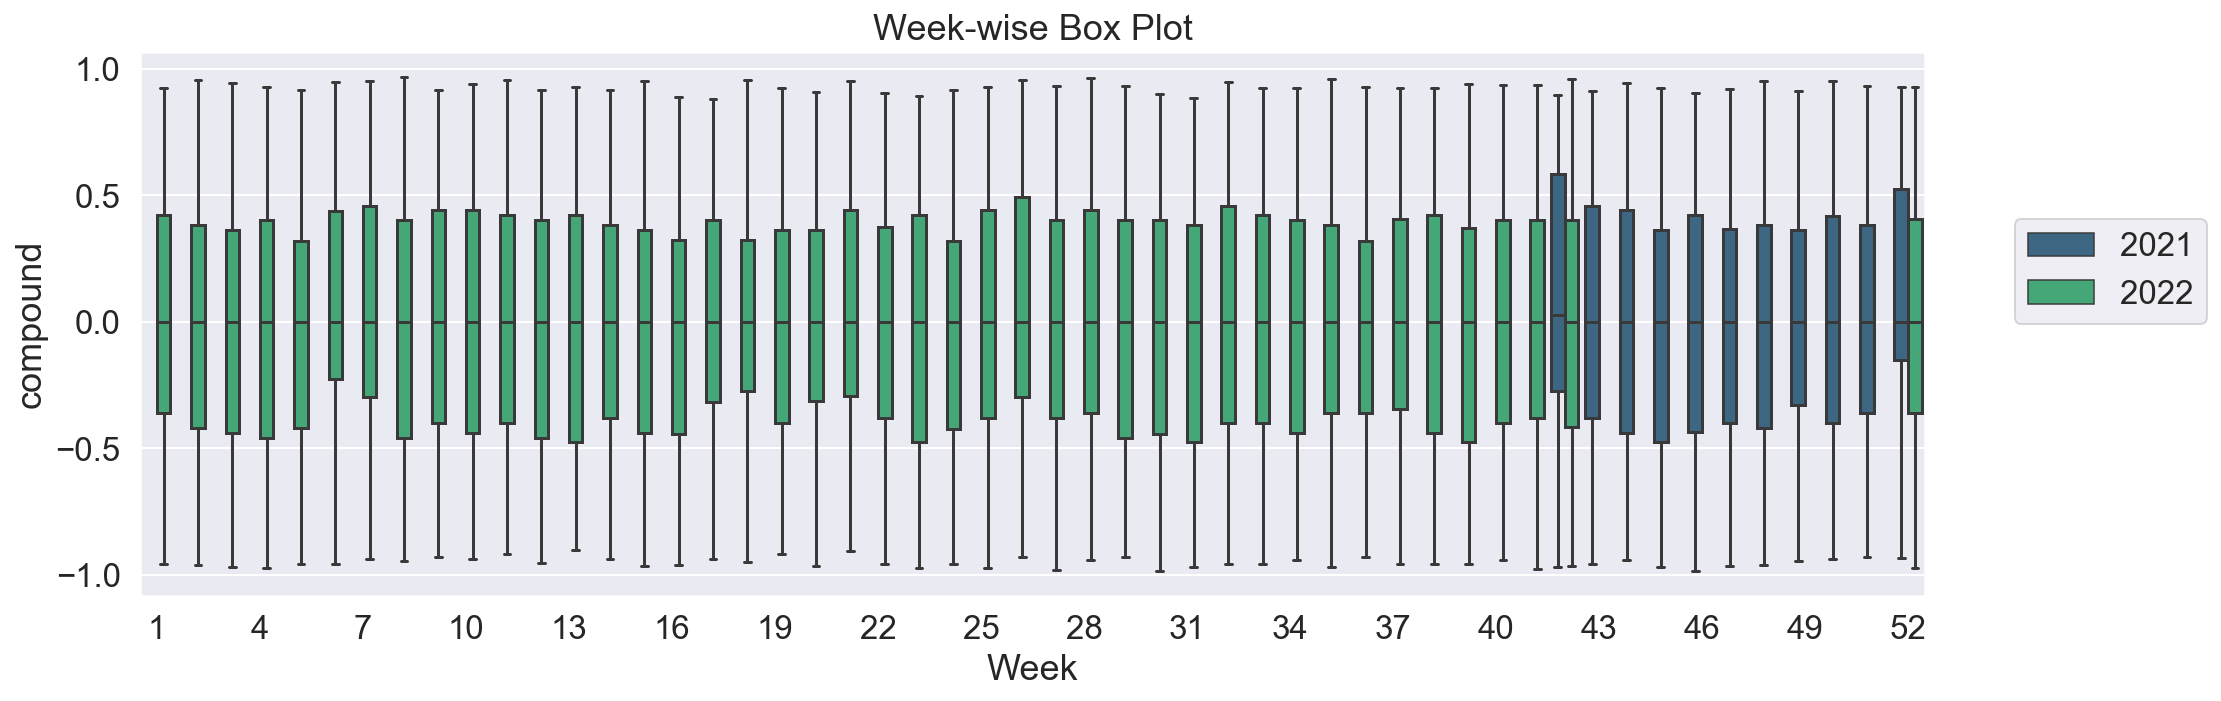

In [246]:
# Draw Plot

styles()

ax = sns.boxplot(x='Week', y='compound', data=df, palette='viridis', hue="Year");


#styling
temp = ax.xaxis.get_ticklabels()
#skip every 7th label, it was over crowded
temp = list(set(temp) - set(temp[::3]))
for label in temp:
    label.set_visible(False)

# Set Title
plt.title('Week-wise Box Plot', fontsize=18);

plt.legend(loc=(1.05, 0.5))
plt.show();

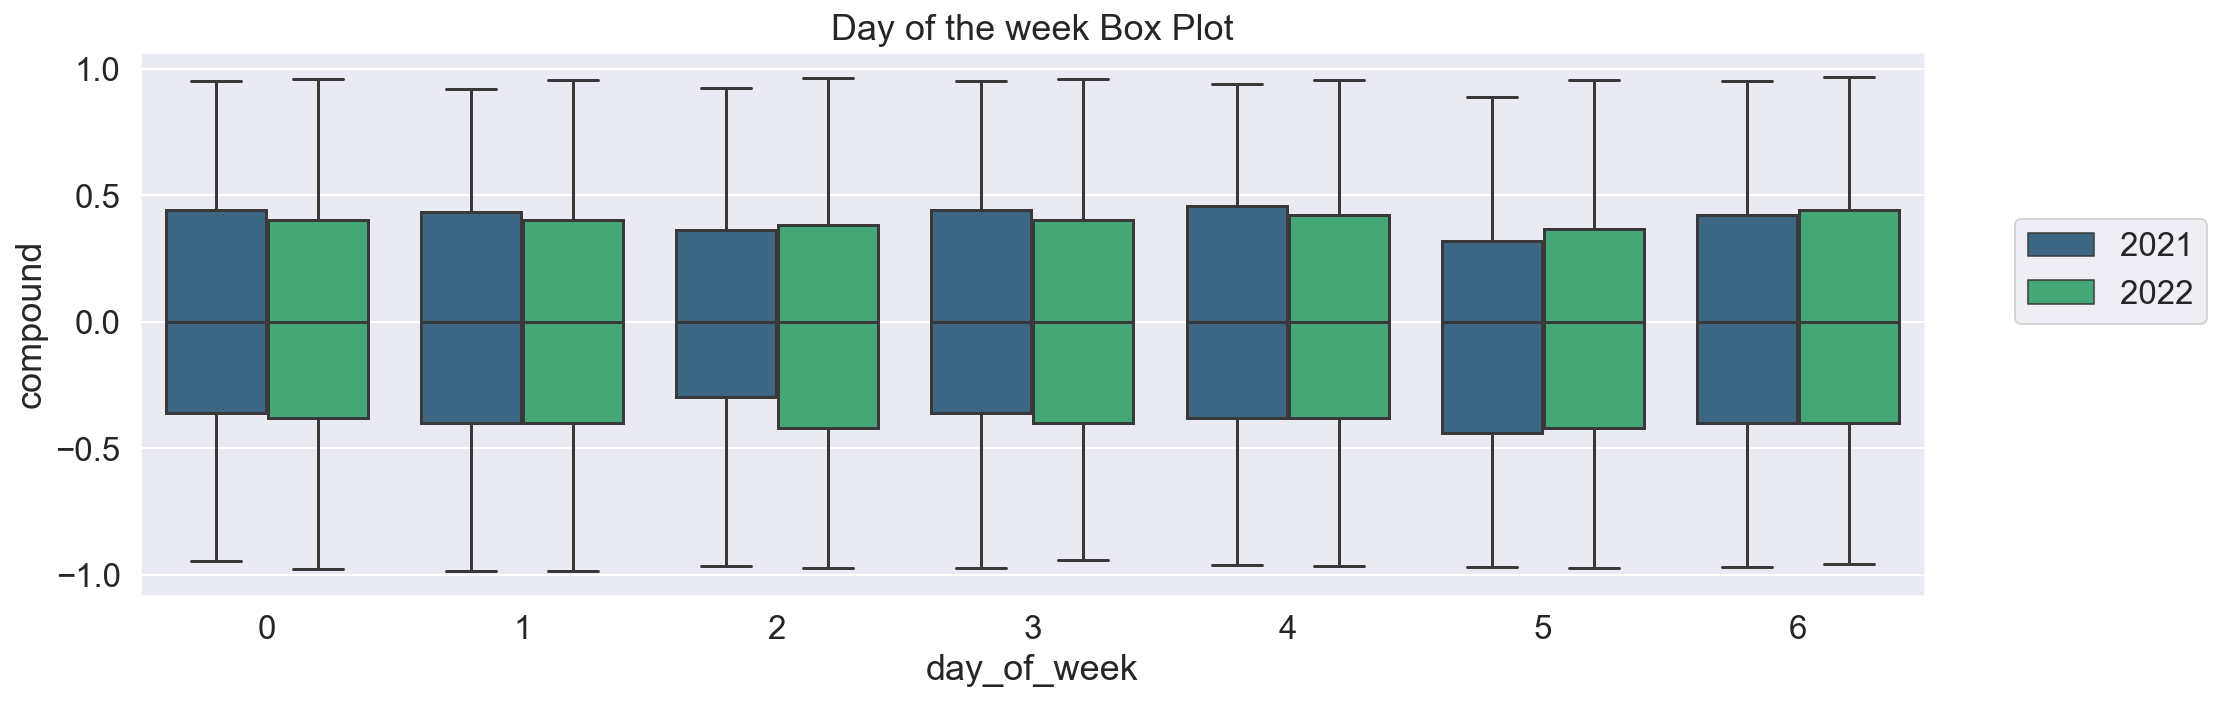

In [247]:
# Draw Plot
styles()
sns.boxplot(x='day_of_week', y='compound', data=df, palette='viridis', hue="Year");

# Set Title

plt.title('Day of the week Box Plot', fontsize=18); 

plt.legend(loc=(1.05, 0.5))

plt.show();

## Boris/Liz/Rishi

In [231]:
df_boris = df[df['tweet_clean'].str.contains("boris", case=False)]
#df_boris.describe()

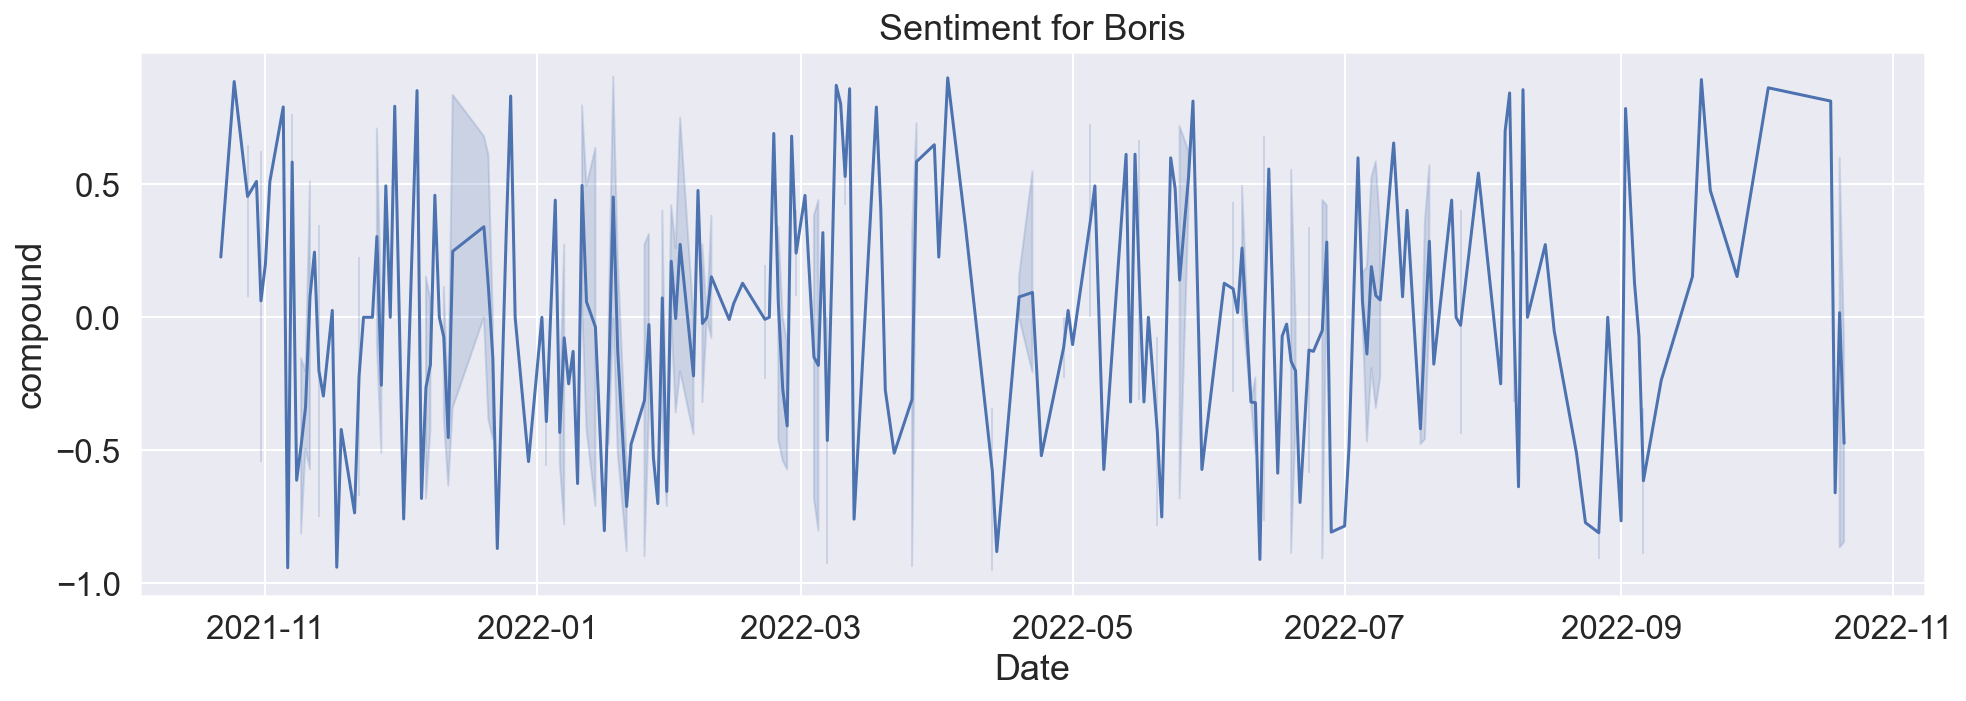

In [74]:
styles();

sns.lineplot(x=df_boris['Date'], y=df_boris['compound']);

plt.title("Sentiment for Boris");

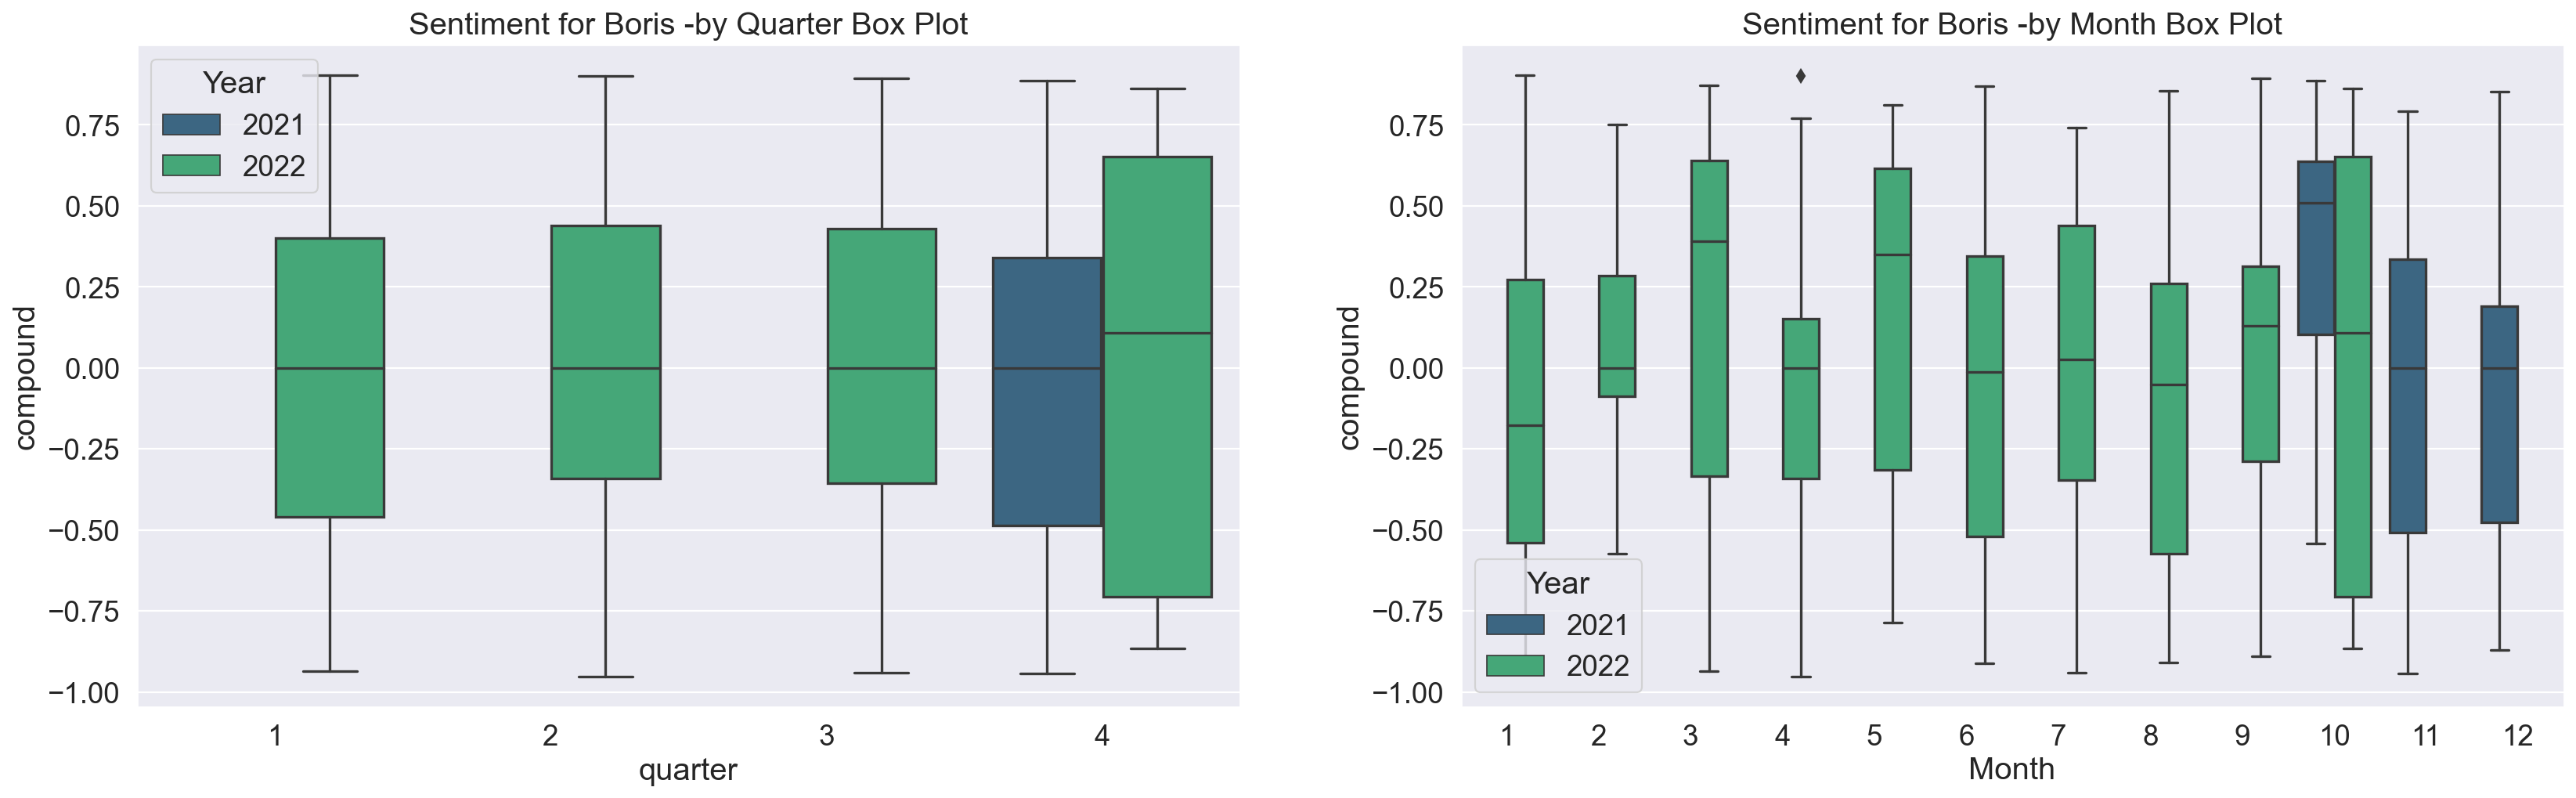

In [75]:
fig, axes = plt.subplots(1, 2, figsize=(25,7), dpi= 80)


sns.boxplot(x='quarter', y='compound', data=df_boris, ax=axes[0] , palette='viridis', hue="Year")
sns.boxplot(x='Month', y='compound', data=df_boris, ax=axes[1], palette='viridis', hue="Year");

# Set Title
axes[0].set_title('Sentiment for Boris -by Quarter Box Plot', fontsize=18);
axes[1].set_title('Sentiment for Boris -by Month Box Plot', fontsize=18);


plt.show();

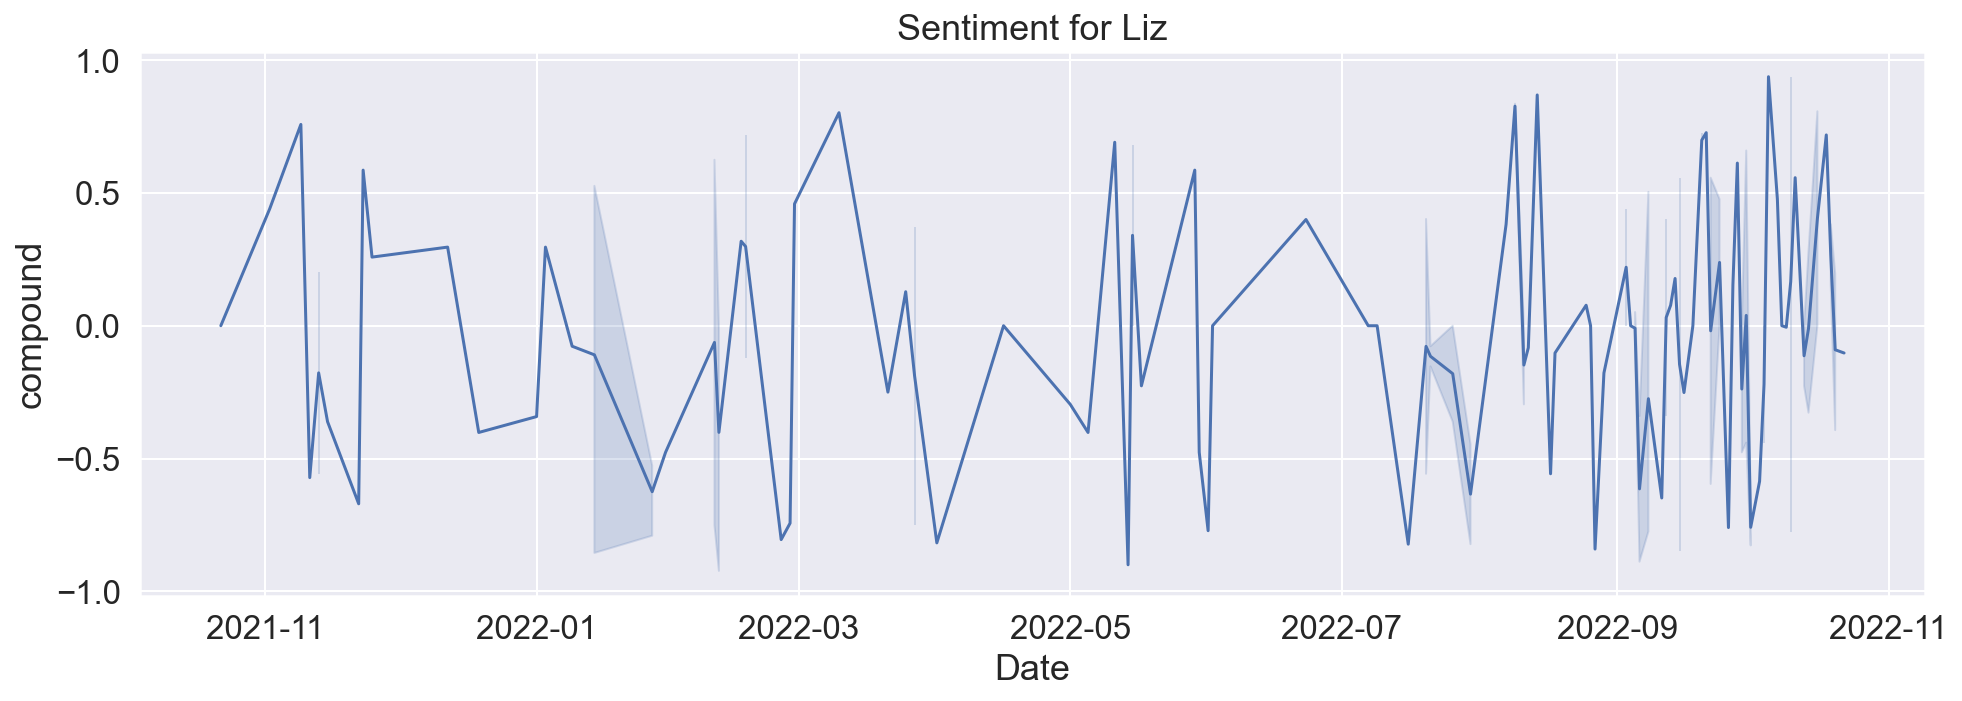

In [76]:
styles();
df_liz = df[df['tweet_clean'].str.contains("liz", case=False)]

sns.lineplot(x=df_liz['Date'], y=df_liz['compound']);

plt.title("Sentiment for Liz");

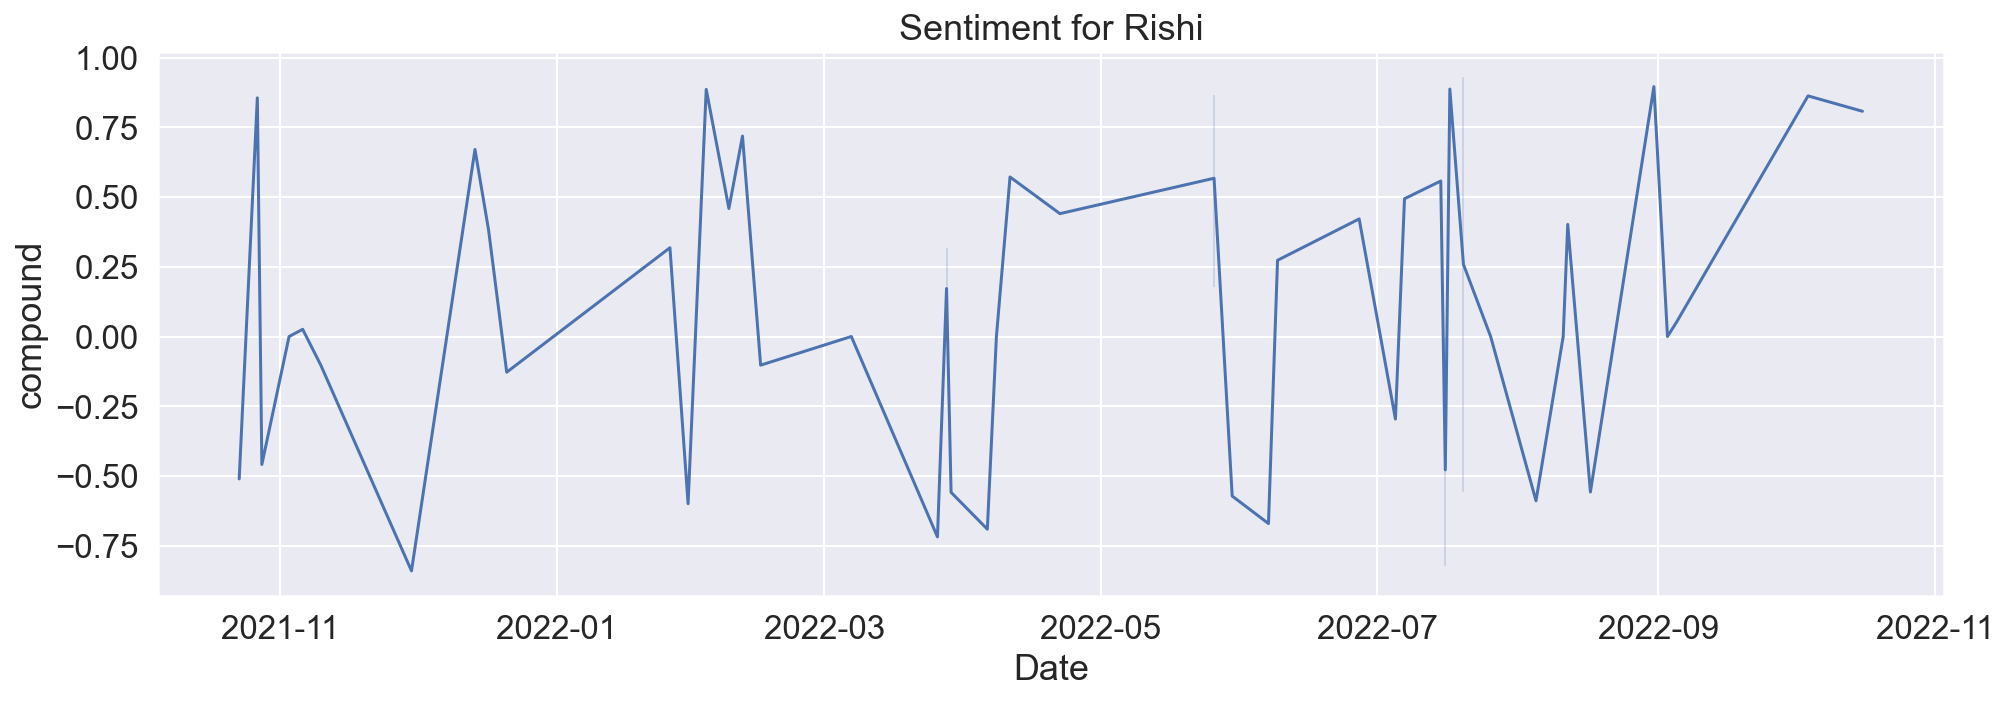

In [233]:
styles();
df_Rishi = df[df['tweet_clean'].str.contains("Rishi", case=False)]

sns.lineplot(x=df_Rishi['Date'], y=df_Rishi['compound']);

plt.title("Sentiment for Rishi");

<Figure size 1152x360 with 0 Axes>

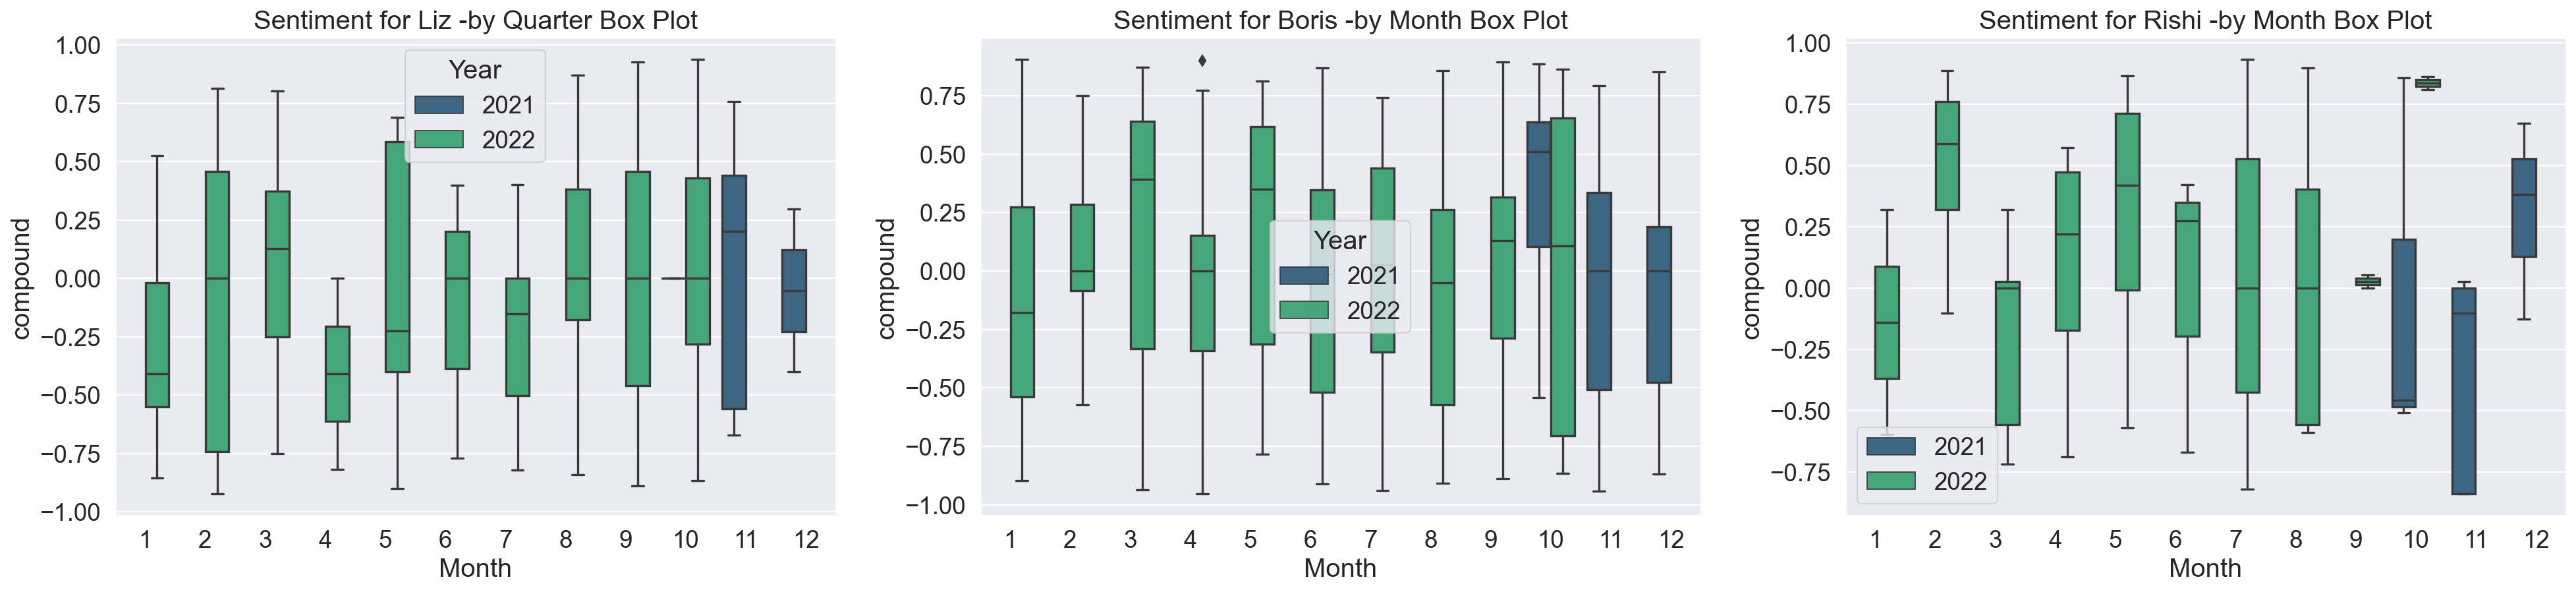

In [78]:
styles();

fig, axes = plt.subplots(1, 3, figsize=(30,6), dpi= 80);
sns.boxplot(x='Month', y='compound', data=df_liz, ax=axes[0], palette='viridis', hue="Year");
sns.boxplot(x='Month', y='compound', data=df_boris, ax=axes[1], palette='viridis', hue="Year");
sns.boxplot(x='Month', y='compound', data=df_Rishi, ax=axes[2], palette='viridis', hue="Year");
# Set Title
axes[0].set_title('Sentiment for Liz -by Quarter Box Plot', fontsize=18);
axes[1].set_title('Sentiment for Boris -by Month Box Plot', fontsize=18);
axes[2].set_title('Sentiment for Rishi -by Month Box Plot', fontsize=18);

plt.legend(loc='lower left');
plt.show();

## How to Check if Time Series Data is Stationary with Python
Test to check if the data is stationary or has a strong trend of seasonality

In [395]:
X = df_cmpd_avg.compound
split = round(len(X) / 2)
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))


mean1=0.009125, mean2=0.003178
variance1=0.238447, variance2=0.236053


In [396]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(X)
print('Augmented Dickey-Fuller test Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

Augmented Dickey-Fuller test Statistic: -32.265457
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


Augmented Dickey-Fuller statistics is -32.265457. Therefore the null hypothesis is rejected. We have a **stationary** dataset.

# Average Sentiment

In [347]:
df_new=df[['Date', 'compound']]
df_new.sort_values(by='Date', inplace=True)

df_new["Date"]= pd.to_datetime(df_new["Date"])

compound_avg = df_new.resample('D', on='Date').mean()
compound_week = df_new.resample('W', on='Date').mean()
compound_month = df_new.resample('M', on='Date').mean()

compound_avg.rename(columns={'compound': 'compound_daily'}, inplace=True)
compound_week.rename(columns={'compound': 'compound_week'}, inplace=True)
compound_month.rename(columns={'compound': 'compound_month'}, inplace=True)

In [348]:
compound_avg

compound_daily
Date                      
2021-10-22        0.106962
2021-10-23        0.070511
2021-10-24        0.147244
2021-10-25        0.133264
2021-10-26        0.049376
...                    ...
2022-10-18       -0.038562
2022-10-19        0.046087
2022-10-20        0.063536
2022-10-21       -0.045813
2022-10-22       -0.051613

[366 rows x 1 columns]

In [349]:
#df_new['day'] = df_new.index.apply(lambda x: x.Date()) 
#davg.reset_index('Date/Time', inplace=True)

df_cmpd_avg = pd.merge(df_new, compound_avg, on='Date')
#df_cmpd_2 = pd.merge(df_cmpd_avg , compound_week,left_by="Date")
#df_cmpd_avg = pd.merge(df_cmpd_avg , compound_month, left_on='Date',right_on='Date')

#df_cmpd_avg

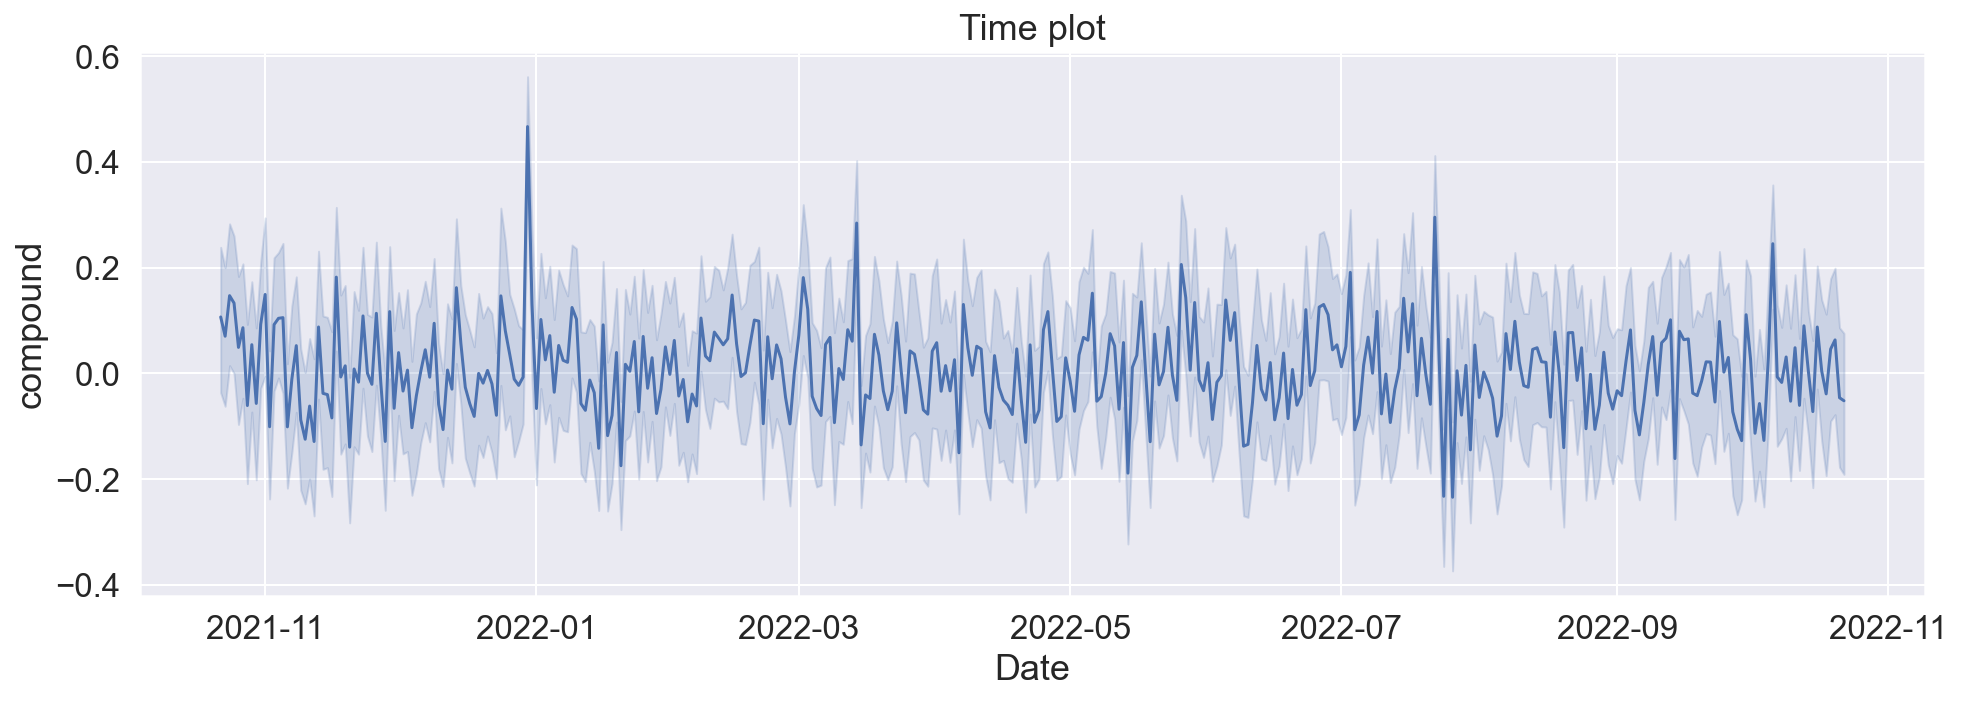

In [350]:
styles();

sns.lineplot(x=df_cmpd_avg['Date'], y=df_cmpd_avg['compound']);

plt.title("Time plot");

In [351]:
#pip install skforecast
#pip install xgboost

# Modeling and Forecasting

In [352]:
# ==============================================================================
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from lightgbm import LGBMRegressor

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

from joblib import dump, load

# Warnings configuration
# ==============================================================================
import warnings
# warnings.filterwarnings('ignore')

In [353]:
type(df_cmpd_avg)

pandas.core.frame.DataFrame

In [354]:
df_cmpd_avg

Date  compound  compound_daily
0     2021-10-22  0.670501        0.106962
1     2021-10-22 -0.318199        0.106962
2     2021-10-22  0.177901        0.106962
3     2021-10-22 -0.801999        0.106962
4     2021-10-22  0.872001        0.106962
...          ...       ...             ...
18476 2022-10-22 -0.401899       -0.051613
18477 2022-10-22  0.440401       -0.051613
18478 2022-10-22  0.401901       -0.051613
18479 2022-10-22  0.726901       -0.051613
18480 2022-10-22  0.631201       -0.051613

[18481 rows x 3 columns]

In [355]:
df_cmpd_avg['Date'].min()
df_cmpd_avg['Date'].max()

Timestamp('2022-10-22 00:00:00')

In [356]:
compound_avg.reset_index('Date', inplace=True)

In [357]:
compound_avg

Date  compound_daily
0   2021-10-22        0.106962
1   2021-10-23        0.070511
2   2021-10-24        0.147244
3   2021-10-25        0.133264
4   2021-10-26        0.049376
..         ...             ...
361 2022-10-18       -0.038562
362 2022-10-19        0.046087
363 2022-10-20        0.063536
364 2022-10-21       -0.045813
365 2022-10-22       -0.051613

[366 rows x 2 columns]

In [358]:
compound_avg['Date'] = pd.to_datetime(compound_avg['Date'], format='%Y/%m/%d')
compound_avg = compound_avg.set_index('Date')
compound_avg = compound_avg.asfreq('D')

In [359]:
#df_cmp = compound_avg.asfreq('D')
df_cmp = compound_avg.sort_index()

In [360]:
df_cmp

compound_daily
Date                      
2021-10-22        0.106962
2021-10-23        0.070511
2021-10-24        0.147244
2021-10-25        0.133264
2021-10-26        0.049376
...                    ...
2022-10-18       -0.038562
2022-10-19        0.046087
2022-10-20        0.063536
2022-10-21       -0.045813
2022-10-22       -0.051613

[366 rows x 1 columns]

Train dates : 2021-10-22 00:00:00 --- 2022-09-22 00:00:00  (n=336)
Test dates  : 2022-09-23 00:00:00 --- 2022-10-22 00:00:00  (n=30)


<Figure size 1152x360 with 0 Axes>

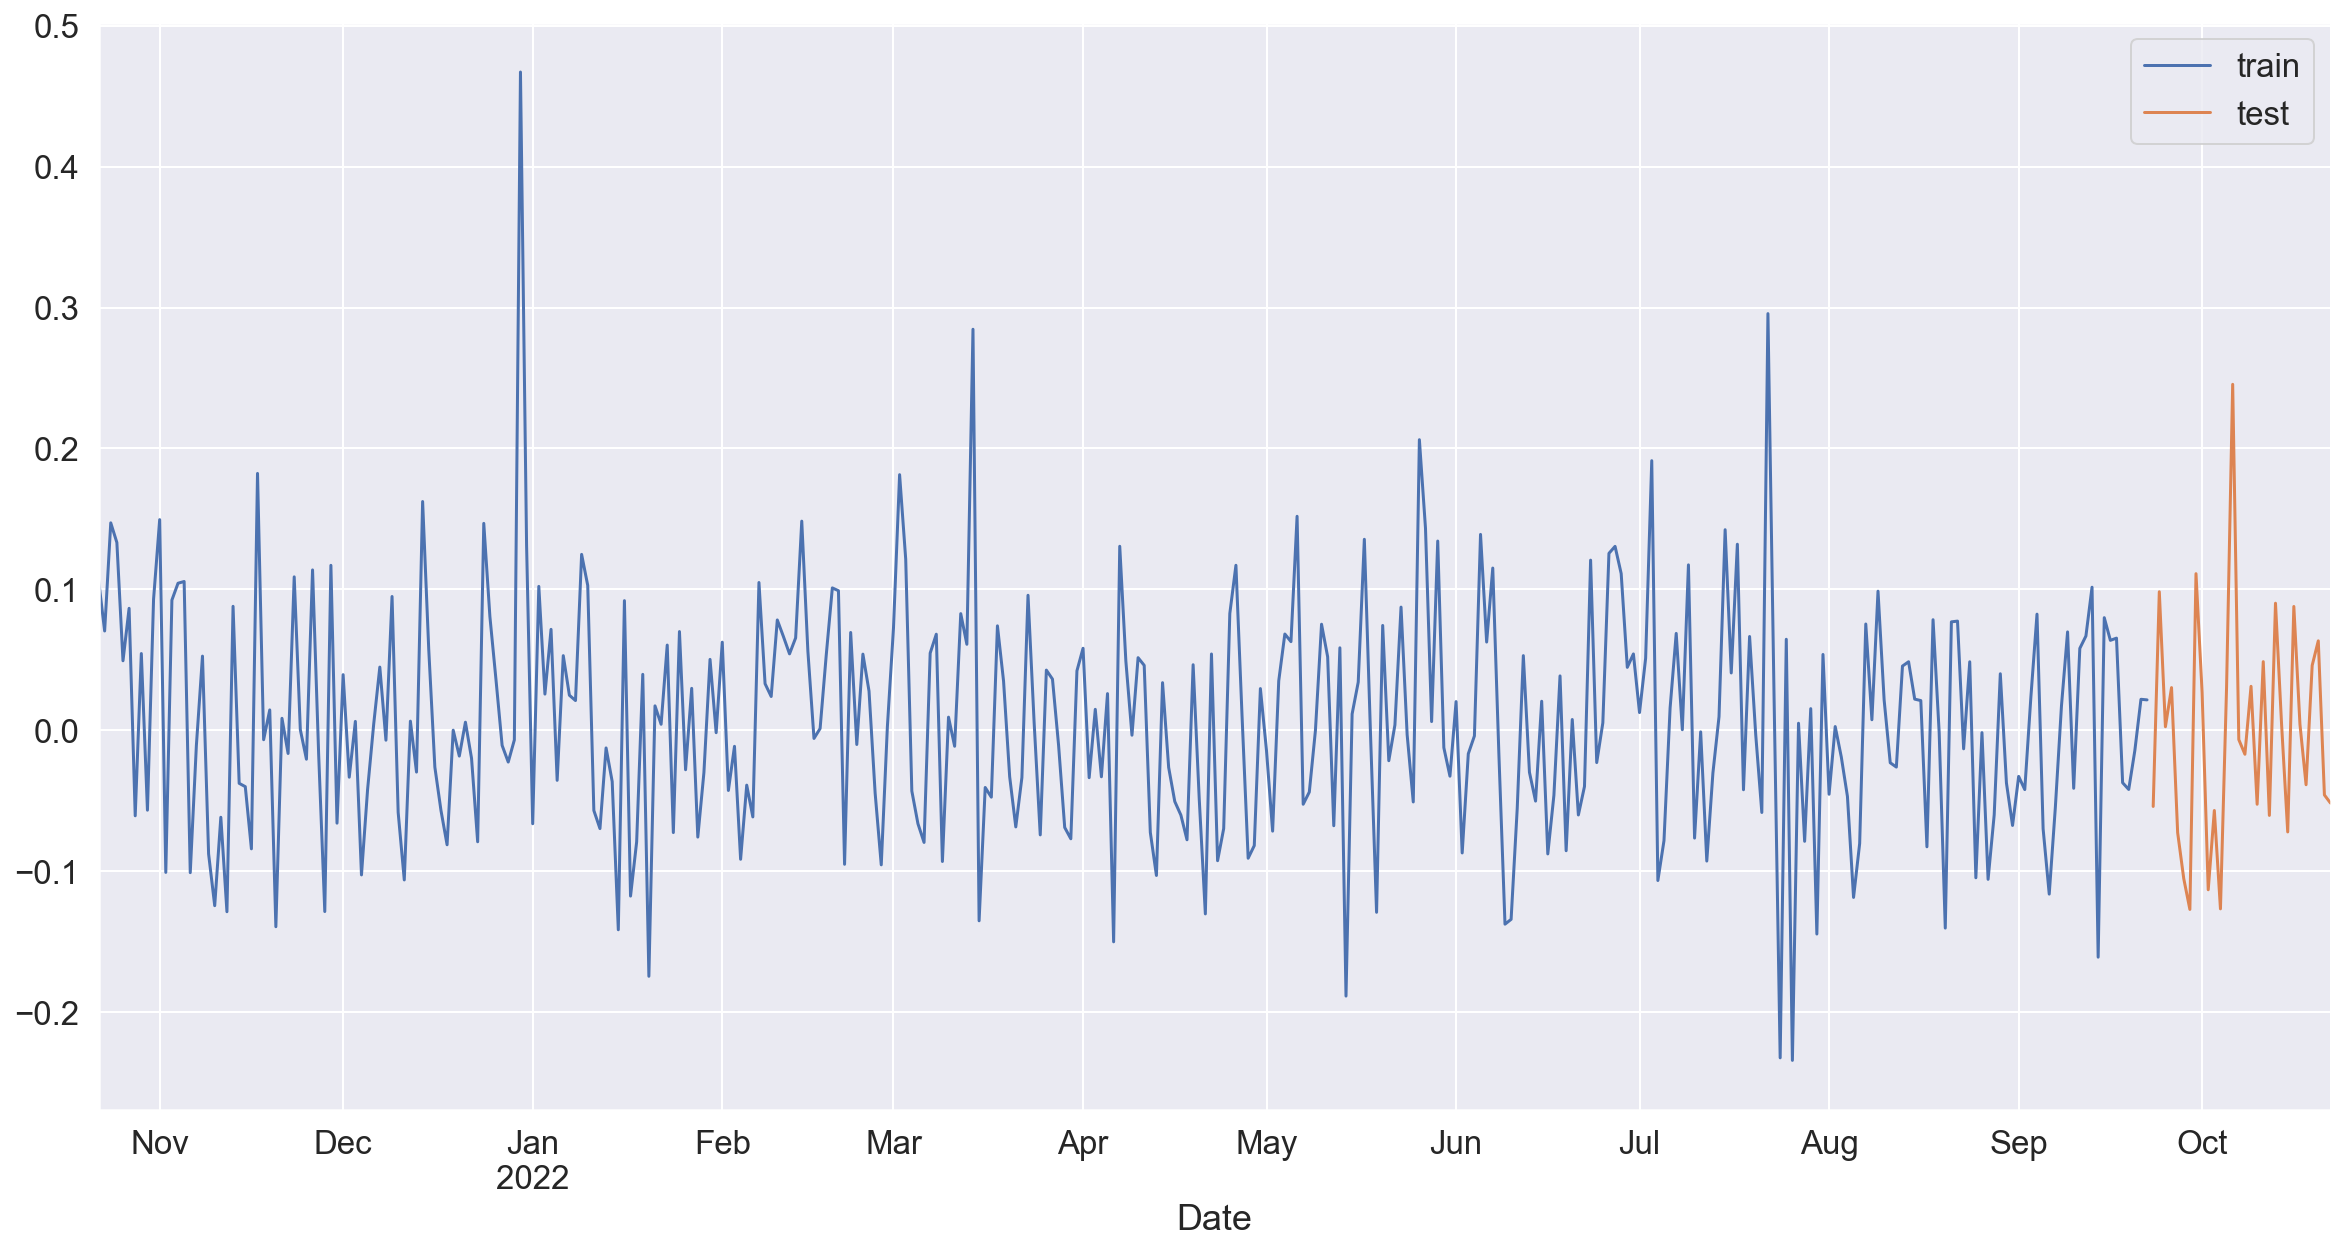

In [361]:

steps = 30 # 30 days
data_train = df_cmp[:-steps]
data_test  = df_cmp[-steps:]

print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

styles();

fig, ax=plt.subplots(figsize=(20, 10))
data_train['compound_daily'].plot(ax=ax, label='train')
data_test['compound_daily'].plot(ax=ax, label='test')


ax.legend();

In [362]:
data_train

compound_daily
Date                      
2021-10-22        0.106962
2021-10-23        0.070511
2021-10-24        0.147244
2021-10-25        0.133264
2021-10-26        0.049376
...                    ...
2022-09-18       -0.037138
2022-09-19       -0.041910
2022-09-20       -0.014293
2022-09-21        0.022052
2022-09-22        0.021636

[336 rows x 1 columns]

### Random Forest Regressor

In [363]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags = 6
                )

forecaster.fit(y=data_train['compound_daily'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [1 2 3 4 5 6] 
Transformer for y: None 
Transformer for exog: None 
Window size: 6 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2021-10-22 00:00:00'), Timestamp('2022-09-22 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
Creation date: 2022-10-29 08:13:49 
Last fit date: 2022-10-29 08:13:49 
Skforecast version: 0.5.1 
Python version: 3.9.6 

## Predictions

In [364]:
# Predictions
# ==============================================================================
steps = 30
predictions = forecaster.predict(steps=steps)
predictions.head(5)

2022-09-23    0.030060
2022-09-24   -0.009148
2022-09-25   -0.020704
2022-09-26    0.003322
2022-09-27    0.047167
Freq: D, Name: pred, dtype: float64

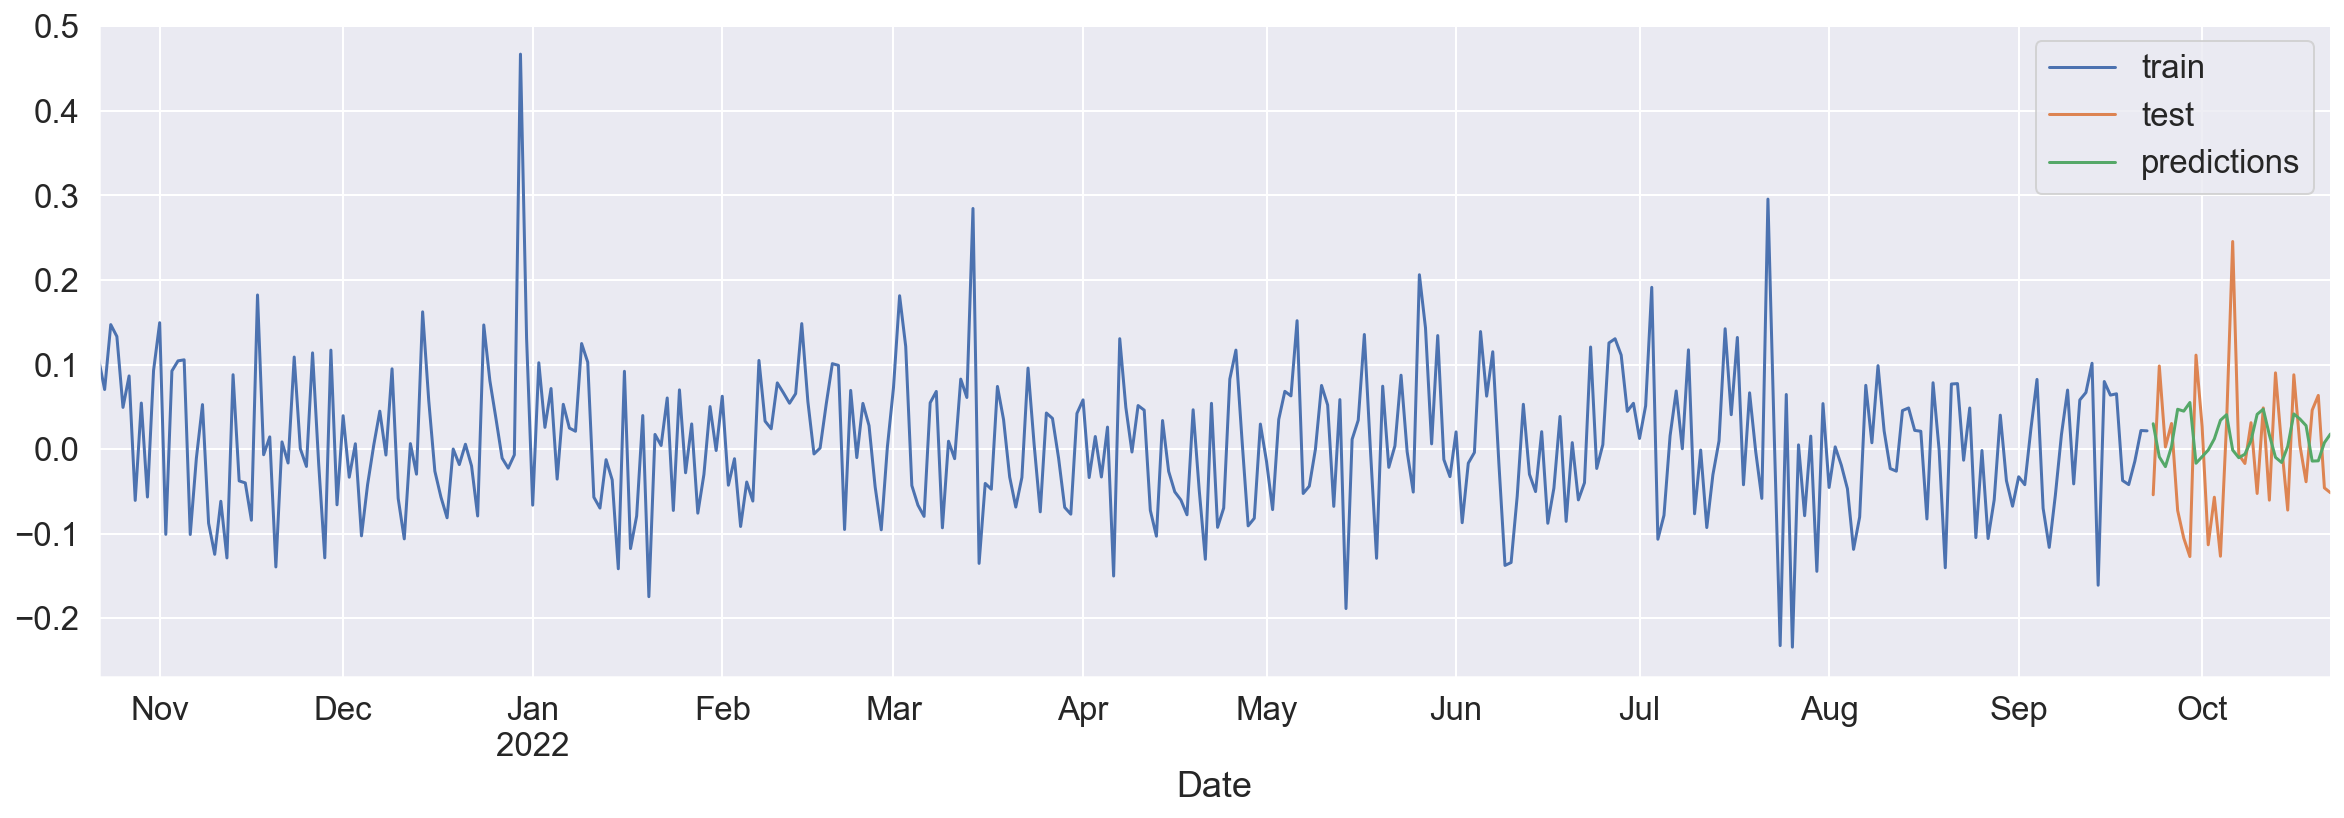

In [365]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(20, 6))
data_train['compound_daily'].plot(ax=ax, label='train')
data_test['compound_daily'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [366]:
# Test error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test['compound_daily'],
                y_pred = predictions
            )

print(f"Test error (mse): {error_mse}")

Test error (mse): 0.008928194051975584


### XGBoost

XGBoost is a very efficient stochastic gradient boosting which is very popular for used. With it's own API and XGBRegressor class that follow scikit learn API make it compatible with skforecast.

In [367]:
# Create and train forecaster
# ==============================================================================
forecasterxgb = ForecasterAutoreg(
                regressor = xgb.XGBRegressor(random_state=123),
                lags = 6
                )

forecasterxgb.fit(y=data_train['compound_daily'])
forecasterxgb

ForecasterAutoreg 
Regressor: XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=123,
             reg_alpha=0, reg_lambda=1, ...) 
Lags: [1 2 3 4 5 6] 
Transformer for y: None 
Transformer for exog: None 
Window size: 6 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2021-10-22 00:00:00'), Timestamp('2022-09-22 00:00:00')] 
Training

In [368]:
# Predictions
# ==============================================================================
steps = 30
predictions = forecasterxgb.predict(steps=steps)
predictions.head(5)

2022-09-23    0.094709
2022-09-24    0.042288
2022-09-25   -0.088059
2022-09-26    0.007194
2022-09-27    0.006653
Freq: D, Name: pred, dtype: float64

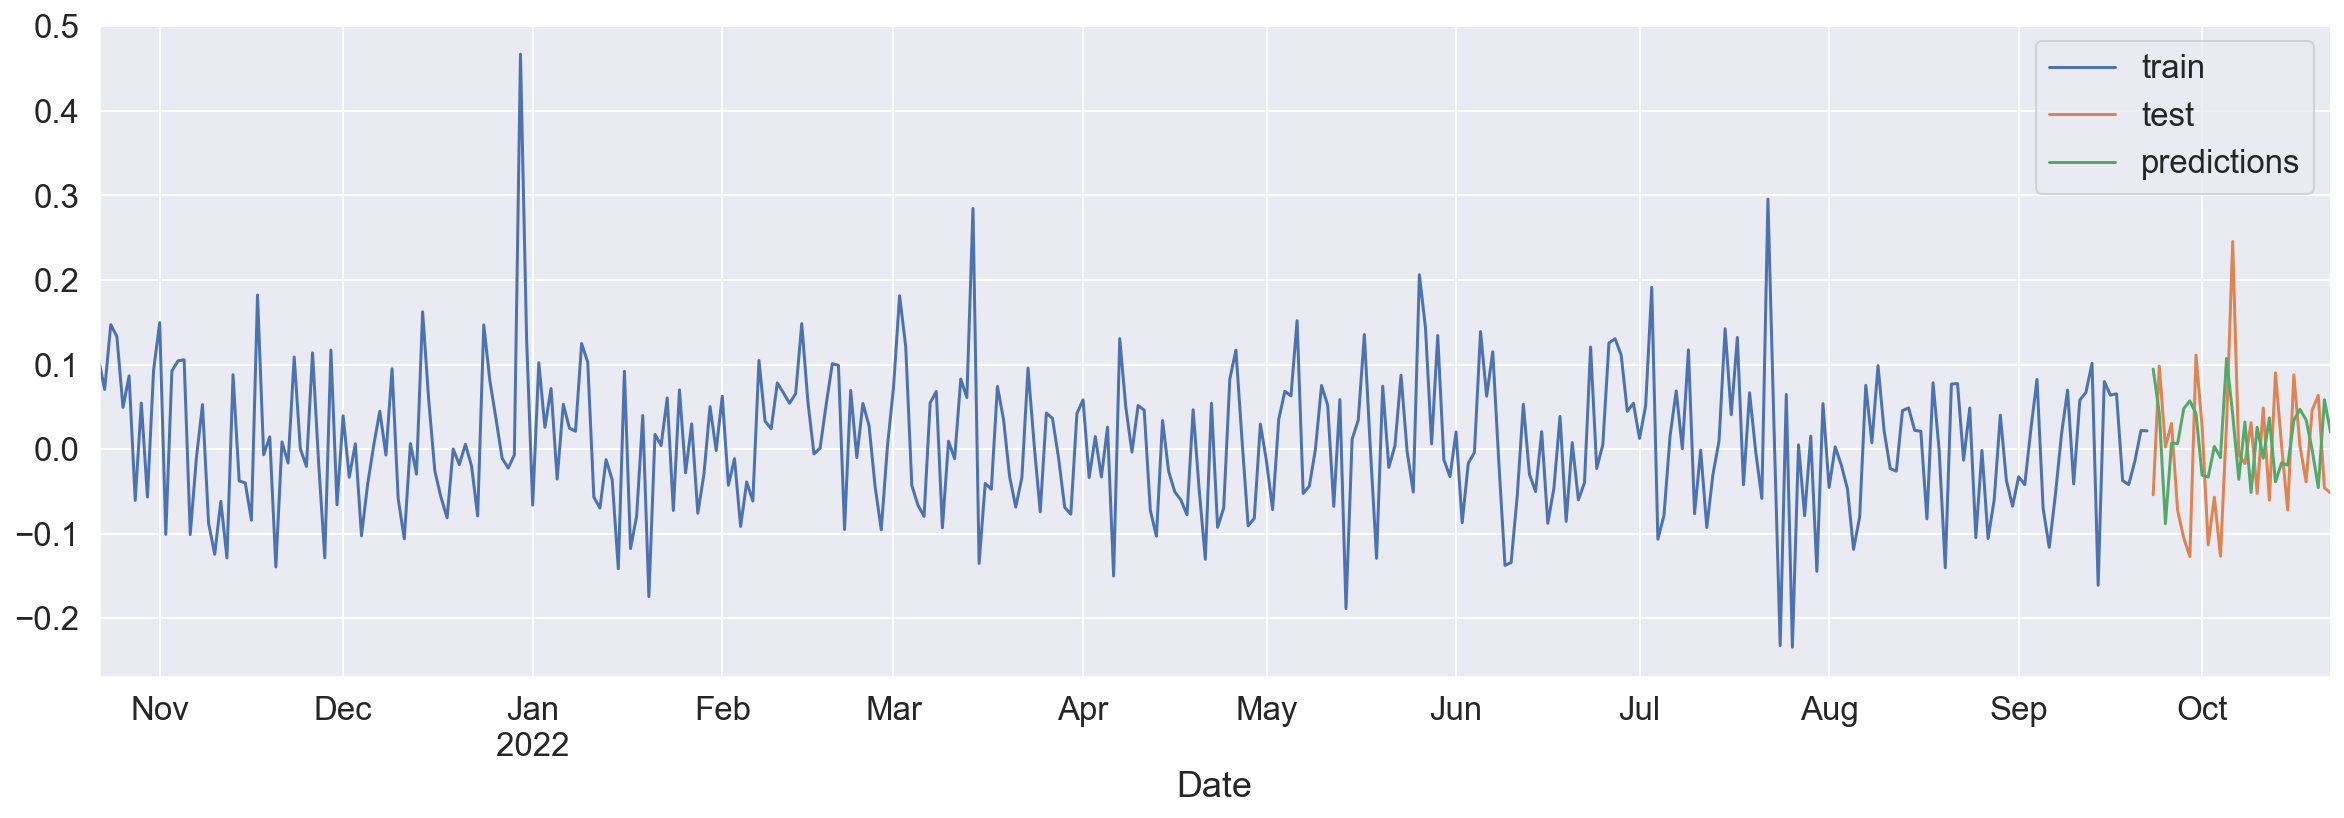

In [369]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(20, 6))
data_train['compound_daily'].plot(ax=ax, label='train')
data_test['compound_daily'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [370]:
# Test error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test['compound_daily'],
                y_pred = predictions
            )

print(f"Test error (mse): {error_mse}")

Test error (mse): 0.00887419969105793


## Hyperparameter tuning for XGBoost

In [412]:
# Grid search of hyperparameters and lags

forecasterxgb = ForecasterAutoreg(
                regressor = xgb.XGBRegressor(random_state=123),
                lags = 6
                )

# Regressor hyperparameters
param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1]
    }

# # Lags used as predictors
lags_grid = [24, 48, 72, [1, 2, 3, 23, 24, 25, 71, 72, 73]]

results_grid = grid_search_forecaster(
    forecaster         = forecasterxgb,
    y                  = data_train['compound_daily'], # Train data
    param_grid         = param_grid,
    lags_grid          = lags_grid,
    steps              = 24, #24
    refit              = False,
    metric             = 'mean_squared_error',
    initial_train_size = int(len(data_train)*0.5), # Model is trained with training data
    fixed_train_size   = False,
    return_best        = True,
    verbose            = False
    )

Number of models compared: 48.


loop lags_grid: 100%|███████████████████████████████████████| 4/4 [00:23<00:00,  5.81s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100}
  Backtesting metric: 0.007127715506443825



In [413]:
results_grid.head(5)

lags  \
10  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]   
11  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]   
5   [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]   
1   [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]   
3   [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]   

                                                           params  \
10   {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100}   
11   {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 500}   
5   {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 500}   
1    {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500}   
3    {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 500}   

    mean_squared_error  learning_rate  max_depth  n_estimators  
10            0.007128           0.10       10.0         100.0  
11            0.007146           0.10       10.0         500.0  
5             0.007153           0.01       10.0         500.0  
1             0.007553           0.01        3.0         500.0  
3             0.007674           0.01        5.0         500.0

## XGBoost using hyperparameters

In [414]:
# Create and train forecaster
# ==============================================================================
forecasterxgb_new = ForecasterAutoreg(
                regressor = xgb.XGBRegressor(max_depth=10, n_estimators=100, learning_rate=0.10, random_state=123),
                lags =24
                )

forecasterxgb_new.fit(y=data_train['compound_daily'])
forecasterxgb_new

ForecasterAutoreg 
Regressor: XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=10, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=123,
             reg_alpha=0, reg_lambda=1, ...) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Transformer for y: None 
Transformer for exog: None 
Window size: 24 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2021-10-22 0

In [415]:
# Predictions
# ==============================================================================
steps = 30
predictions = forecasterxgb.predict(steps=steps)
predictions.head(5)

2022-09-23   -0.006168
2022-09-24   -0.016282
2022-09-25   -0.026155
2022-09-26    0.005994
2022-09-27   -0.018036
Freq: D, Name: pred, dtype: float64

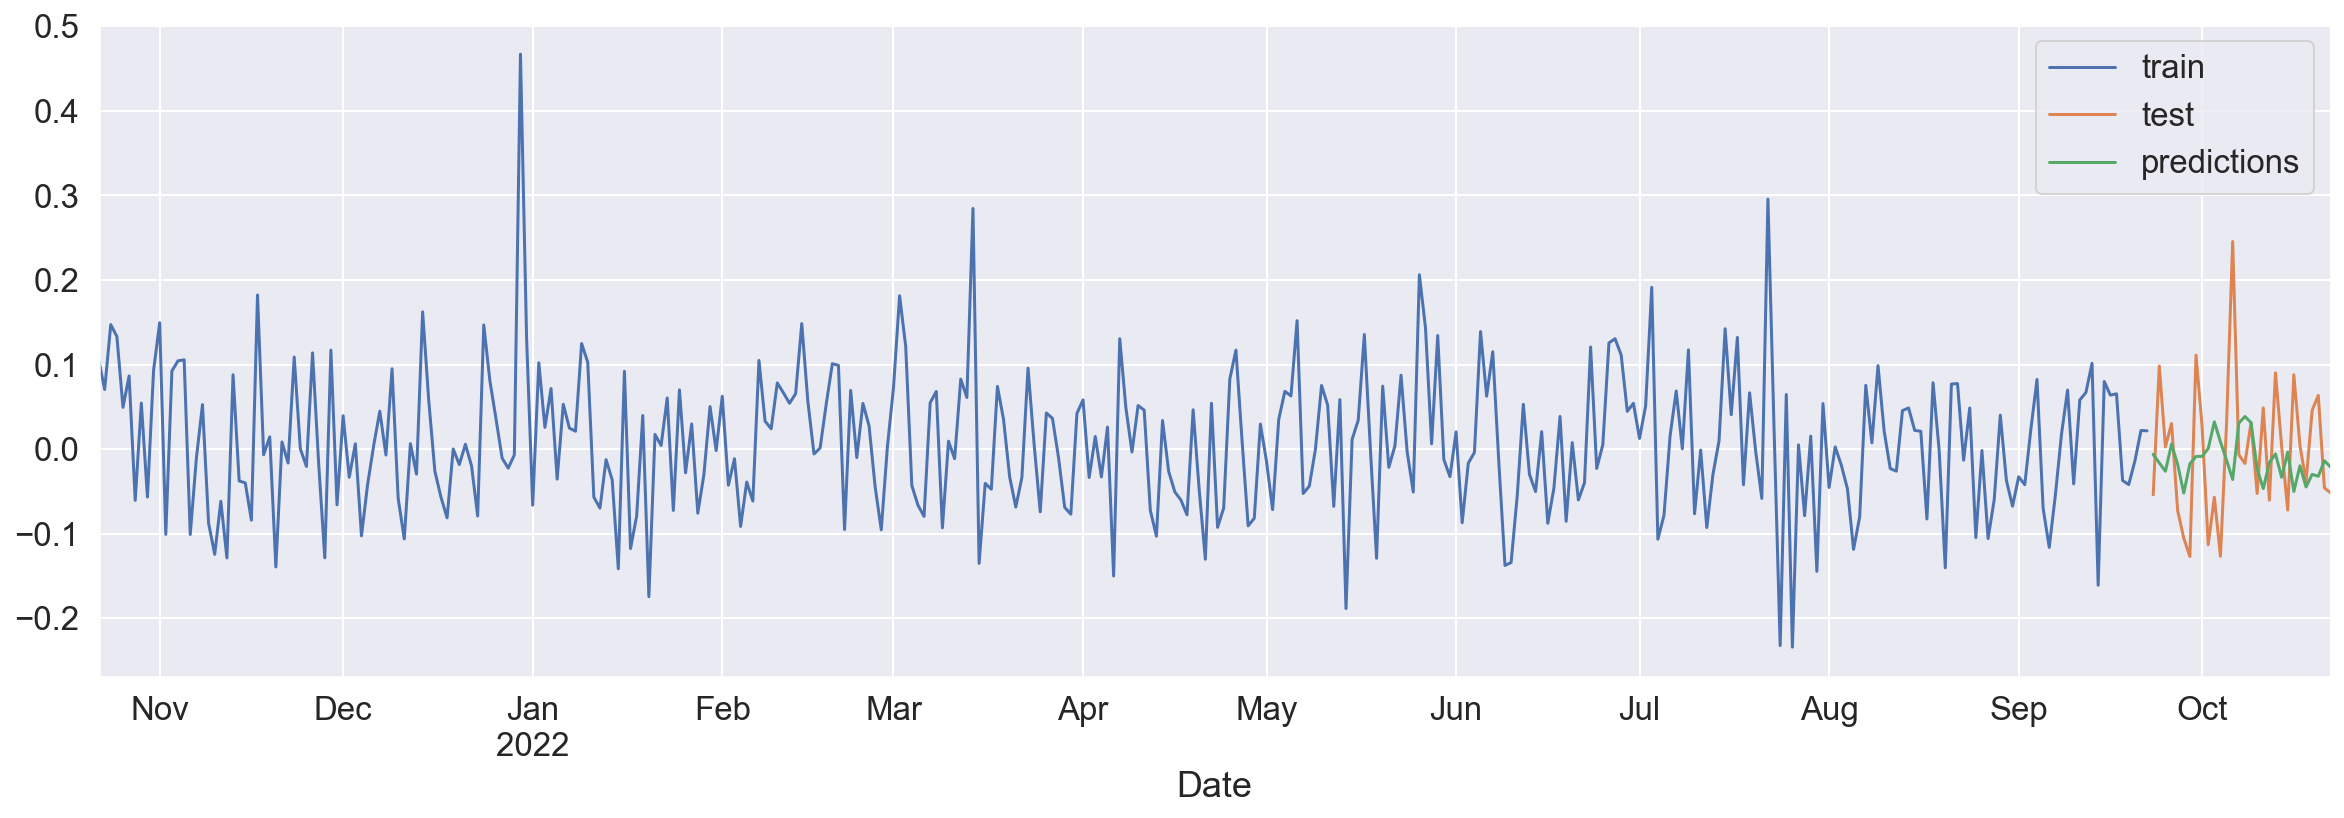

In [416]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(20, 6))
data_train['compound_daily'].plot(ax=ax, label='train')
data_test['compound_daily'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

### Backtesting

In [450]:
# Backtesting
metric, predictions = backtesting_forecaster(
    forecaster = forecasterxgb_new,
    y          = data_train['compound_daily'],
    initial_train_size = 60,
    fixed_train_size   = False,
    steps      = 24,
    refit      = False,
    metric     = 'mean_squared_error',
    verbose    = False # Change to True to see detailed information
)

In [451]:
print(f"Backtest error: {metric}")

Backtest error: 0.009375111930975717


In [452]:
# Index is added to predictions
predictions

pred
2021-12-21  0.007207
2021-12-22 -0.010781
2021-12-23 -0.053921
2021-12-24 -0.072051
2021-12-25 -0.050257
...              ...
2022-09-18 -0.042222
2022-09-19 -0.020848
2022-09-20 -0.056698
2022-09-21 -0.018314
2022-09-22 -0.030465

[276 rows x 1 columns]

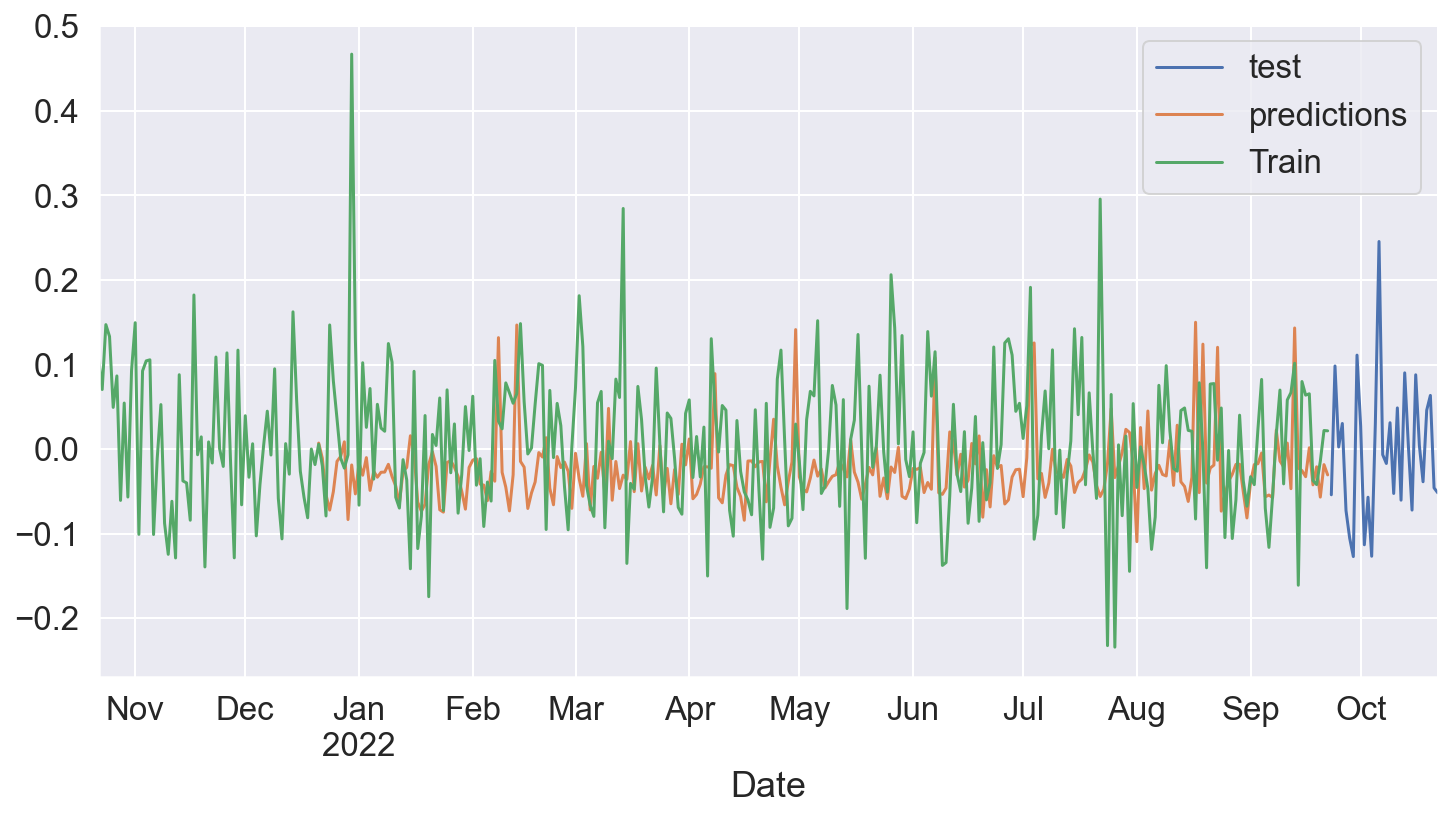

In [453]:
# Plot of predictions
fig, ax = plt.subplots(figsize=(12, 6))
data_test['compound_daily'].plot(ax=ax, label='test')
predictions['pred'].plot(ax=ax, label='predictions')
data_train['compound_daily'].plot(ax=ax, label='Train')
ax.legend();

## LGBM Regressor

In [417]:
# Grid search of hyperparameters and lags

forecasterLGBM = ForecasterAutoreg(
                regressor = LGBMRegressor(random_state=123),
                lags = 6
                )

# Regressor hyperparameters
param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1]
    }

# # Lags used as predictors
lags_grid = [24, 48, 72, [1, 2, 3, 23, 24, 25, 71, 72, 73]]

results_grid = grid_search_forecaster(
    forecaster         = forecasterLGBM,
    y                  = data_train['compound_daily'], # Train data
    param_grid         = param_grid,
    lags_grid          = lags_grid,
    steps              = 24, #24
    refit              = False,
    metric             = 'mean_squared_error',
    initial_train_size = int(len(data_train)*0.5), # Model is trained with training data
    fixed_train_size   = False,
    return_best        = True,
    verbose            = False
    )

Number of models compared: 48.


loop lags_grid: 100%|███████████████████████████████████████| 4/4 [00:07<00:00,  1.86s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
  Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
  Backtesting metric: 0.007095440880235102



In [419]:
results_grid.head(5)

lags  \
0                                                                                                   [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]   
38                                                                                                                                                        [1, 2, 3, 23, 24, 25, 71, 72, 73]   
40                                                                                                                                                        [1, 2, 3, 23, 24, 25, 71, 72, 73]   
36                                                                                                                                                        [1, 2, 3, 23, 24, 25, 71, 72, 73]   
12  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48]   

                                                           params  \
0    {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}   
38   {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100}   
40  {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 100}   
36   {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}   
12   {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}   

    mean_squared_error  learning_rate  max_depth  n_estimators  
0             0.007095           0.01        3.0         100.0  
38            0.007101           0.01        5.0         100.0  
40            0.007101           0.01       10.0         100.0  
36            0.007101           0.01        3.0         100.0  
12            0.007180           0.01        3.0         100.0

In [426]:
# Create and train forecaster
# ==============================================================================
forecasterLGBM = ForecasterAutoreg(
                regressor = LGBMRegressor(max_depth=3, n_estimators=100, learning_rate=0.01, random_state=123),
                lags = 24
                )

forecasterLGBM.fit(y=data_train['compound_daily'])
forecasterLGBM

ForecasterAutoreg 
Regressor: LGBMRegressor(learning_rate=0.01, max_depth=3, random_state=123) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Transformer for y: None 
Transformer for exog: None 
Window size: 24 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2021-10-22 00:00:00'), Timestamp('2022-09-22 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.01, 'max_depth': 3, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': 123, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': 'warn', 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0} 
Creation date: 2022-10-29 10:10:15 
Last fit date: 202

In [429]:
# Predictions
# ==============================================================================
steps = 24
predictions = forecasterLGBM.predict(steps=steps)
predictions.head(5)

2022-09-23    0.006651
2022-09-24    0.001882
2022-09-25    0.017958
2022-09-26   -0.000950
2022-09-27    0.007376
Freq: D, Name: pred, dtype: float64

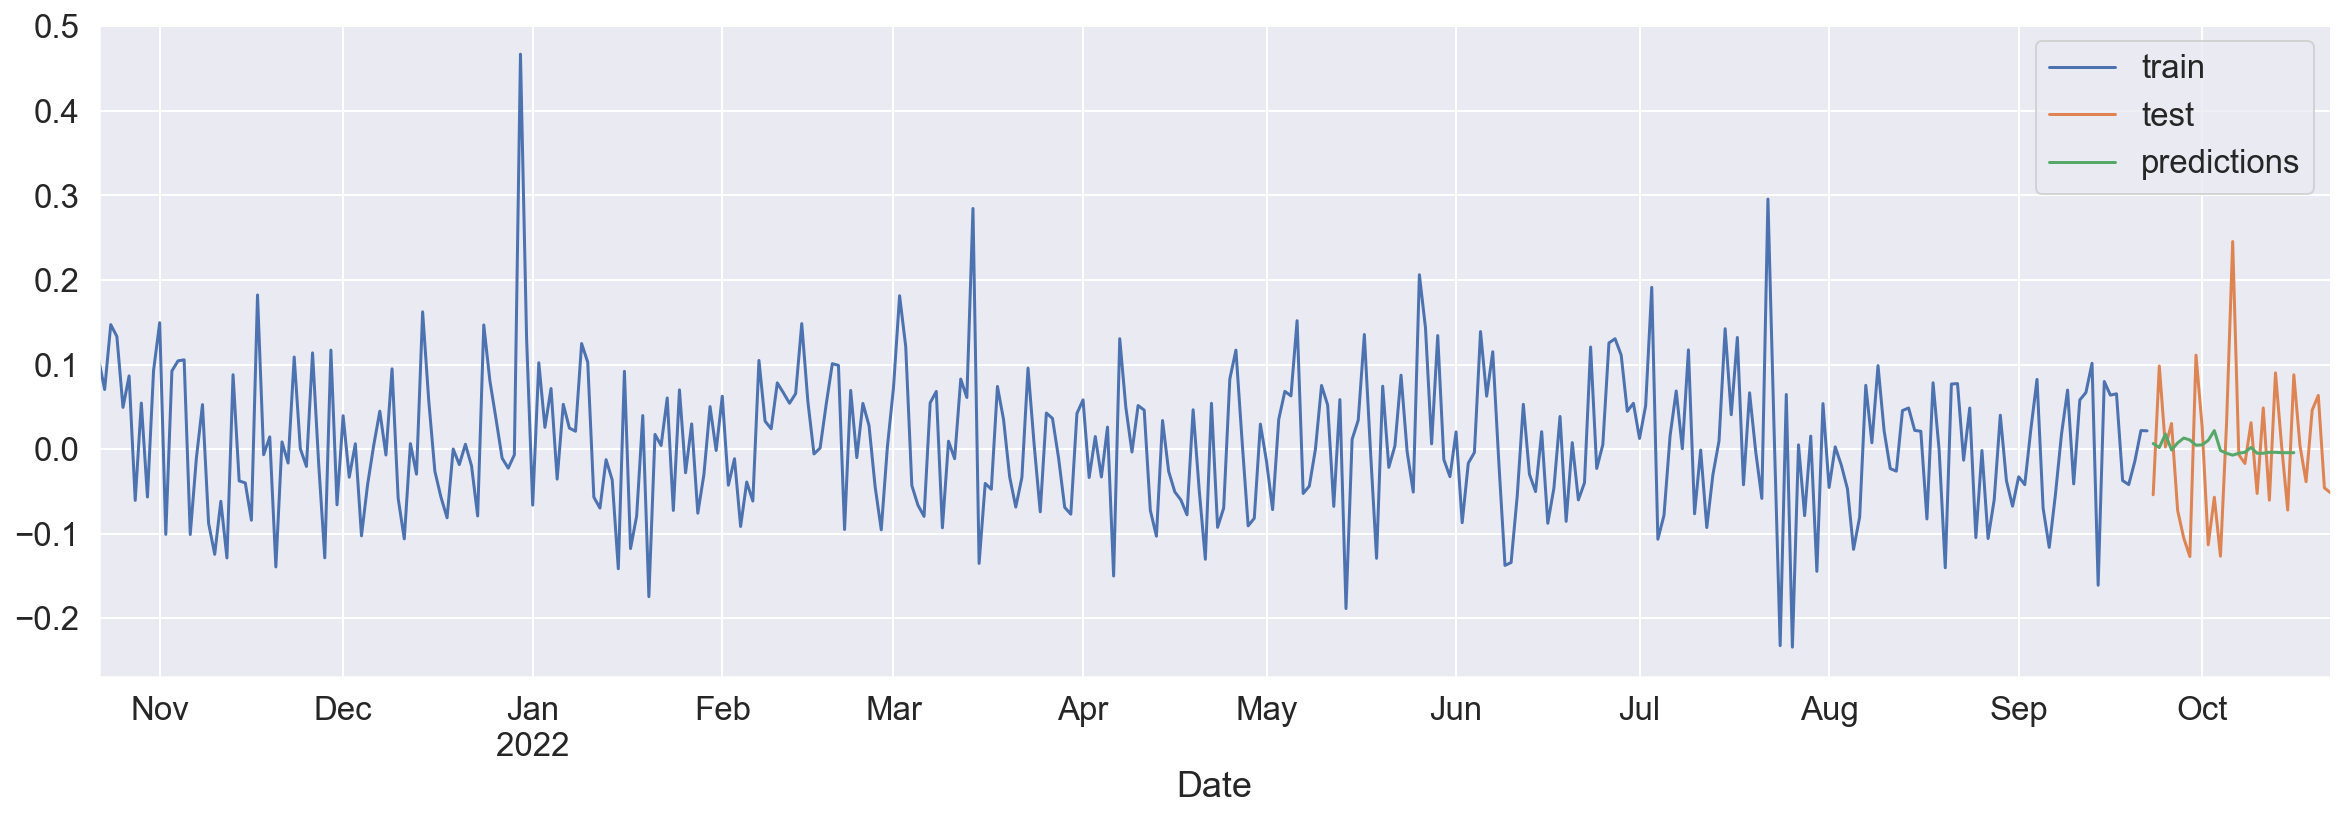

In [430]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(20, 6))
data_train['compound_daily'].plot(ax=ax, label='train')
data_test['compound_daily'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();